# Segmented Cointegration Analysis
## Application to Kilian (2009) Oil Market Data

**Tests implemented:**
- Kim, J.-Y. (2003). *Inference on Segmented Cointegration*. Econometric Theory, 19, 620–639.
- Martins, L.F. & Rodrigues, P.M.M. (2022). *Tests for Segmented Cointegration: An Application to US Government Budgets*. Empirical Economics, 63, 567–600.

**Author:** Dr Merwan Roudane  
**Package:** `segmcoint` v1.0.0  
**Date:** February 2026

## 0. Environment & Watermark

In [1]:
pip install segmcoint==1.0.0

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.3 -> 26.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import sys, platform, datetime

# Watermark — environment information
print("=" * 65)
print("  ENVIRONMENT WATERMARK")
print("=" * 65)
print(f"  Python          : {platform.python_version()}")
print(f"  Platform        : {platform.platform()}")
print(f"  Date            : {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print()

import numpy as np
import pandas as pd
import scipy
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

print(f"  NumPy           : {np.__version__}")
print(f"  Pandas          : {pd.__version__}")
print(f"  SciPy           : {scipy.__version__}")
print(f"  Matplotlib      : {matplotlib.__version__}")
print(f"  Seaborn         : {sns.__version__}")

# Add segmcoint to path
sys.path.insert(0, '.')  # segmcoint package in same directory
import segmcoint
print(f"  segmcoint       : {segmcoint.__version__}")
print(f"  tabulate        : installed")
print("=" * 65)

# imports from segmcoint
from segmcoint import (
    kim_test, mr_test, kim_break_estimator,
    generate_segmented_data, ols_residuals
)
from segmcoint.kim2003 import get_critical_value
from segmcoint.martins_rodrigues2022 import get_mr_critical_value

# Plotting defaults
plt.rcParams.update({
    'figure.figsize': (14, 5),
    'figure.dpi': 120,
    'axes.grid': True,
    'grid.alpha': 0.3,
    'font.size': 11,
    'axes.titlesize': 13,
    'axes.labelsize': 12,
})
sns.set_style("whitegrid")

import warnings
warnings.filterwarnings('ignore')
print("\n✓ All packages loaded successfully.")

  ENVIRONMENT WATERMARK
  Python          : 3.13.7
  Platform        : Windows-11-10.0.26100-SP0
  Date            : 2026-02-06 12:56:47

  NumPy           : 2.3.4
  Pandas          : 2.3.3
  SciPy           : 1.16.3
  Matplotlib      : 3.10.7
  Seaborn         : 0.13.2
  segmcoint       : 1.0.0
  tabulate        : installed

✓ All packages loaded successfully.


---
## 1. Data Loading & Inspection

We use the Kilian (2009) oil market dataset consisting of three monthly variables (1973:02 – 2007:12):

| Variable | Description |
|----------|-------------|
| `dprod`  | Percentage change in global crude oil production |
| `rea`    | Index of real economic activity (dry cargo shipping rates) |
| `rpo`    | Real price of oil (deflated by US CPI) |

**Reference:** Kilian, L. (2009). *Not All Oil Price Shocks Are Alike: Disentangling Demand and Supply Shocks in the Crude Oil Market*. American Economic Review, 99(3), 1053–1069.

In [4]:
import os
print(f"\nCurrent working directory: {os.getcwd()}")


Current working directory: c:\Users\HP\Downloads


In [5]:
import pandas as pd

In [9]:
import os

path = r"c:\Users\HP\Downloads\Copy_of_Killian.xlsx"
print("Exists:", os.path.exists(path))
print("Absolute:", os.path.abspath(path))


Exists: False
Absolute: c:\Users\HP\Downloads\Copy_of_Killian.xlsx


In [10]:
import glob, os

# 1) Show Excel files in the folder you tried
print(glob.glob(r"c:\Users\HP\Downloads\*.xls*"))

# 2) Also check the common OneDrive Downloads location
print(glob.glob(r"c:\Users\HP\OneDrive\Downloads\*.xls*"))

# 3) If still nothing, search recursively in your user folder (may take a bit)
matches = glob.glob(r"c:\Users\HP\**\*Killian*.xls*", recursive=True)
print(matches[:50])   # show first 50 matches
print("Total found:", len(matches))


['c:\\Users\\HP\\Downloads\\1. dataset from IMF_USA_JPN_GER_UKG_FRA.xlsx', 'c:\\Users\\HP\\Downloads\\afc_acm_LONG_100plus.xlsx', 'c:\\Users\\HP\\Downloads\\aissadata.xlsx', 'c:\\Users\\HP\\Downloads\\ARDL data.xls', 'c:\\Users\\HP\\Downloads\\causality fp w.xlsx', 'c:\\Users\\HP\\Downloads\\causality_test_results.xlsx', 'c:\\Users\\HP\\Downloads\\Classeur (1).xlsx', 'c:\\Users\\HP\\Downloads\\Classeur.xlsx', 'c:\\Users\\HP\\Downloads\\cleaned_green_bond_data.xlsx', 'c:\\Users\\HP\\Downloads\\clean_data.xlsx', 'c:\\Users\\HP\\Downloads\\clean_data_renamed.xlsx', 'c:\\Users\\HP\\Downloads\\coffe1.xlsx', 'c:\\Users\\HP\\Downloads\\coffee_data.xlsx', 'c:\\Users\\HP\\Downloads\\composite_indicators_20251114_232839.xlsx', 'c:\\Users\\HP\\Downloads\\composite_indicators_20251114_235157.xlsx', 'c:\\Users\\HP\\Downloads\\composite_indicators_20251223_214045.xlsx', 'c:\\Users\\HP\\Downloads\\composite_indicator_pca.xlsx', 'c:\\Users\\HP\\Downloads\\Copy of Killian.xlsx', 'c:\\Users\\HP\\Downloa

In [11]:
# ── Load Excel data ──────────────────────────────────────────
import openpyxl

path = r"c:\Users\HP\Downloads\Copy of Killian.xlsx"
wb = openpyxl.load_workbook(path)
ws = wb.active



rows = []
for row in ws.iter_rows(min_row=2, max_row=ws.max_row, values_only=True):
    if row[0] is not None:
        rows.append(row[:4])

df = pd.DataFrame(rows, columns=['date', 'dprod', 'rea', 'rpo']).astype(float)

# Create proper datetime index
years  = df['date'].astype(int)
months = ((df['date'] - years) * 100 + 0.5).astype(int)
df.index = pd.to_datetime(
    [f"{y}-{m:02d}-01" for y, m in zip(years, months)]
)
df.index.name = 'Date'

T = len(df)
print(f"Sample : {df.index[0].strftime('%Y:%m')} – {df.index[-1].strftime('%Y:%m')}")
print(f"T      : {T} observations\n")

# Display first and last rows
print(tabulate(
    df[['dprod', 'rea', 'rpo']].head(8),
    headers='keys', tablefmt='fancy_grid', floatfmt='.4f',
    showindex=True
))
print("\n  ⋮\n")
print(tabulate(
    df[['dprod', 'rea', 'rpo']].tail(5),
    headers='keys', tablefmt='fancy_grid', floatfmt='.4f',
    showindex=True
))

Sample : 1973:02 – 2007:12
T      : 419 observations

╒═════════════════════╤══════════╤═════════╤══════════╕
│ Date                │    dprod │     rea │      rpo │
╞═════════════════════╪══════════╪═════════╪══════════╡
│ 1973-02-01 00:00:00 │  11.8773 │ 36.0642 │ -47.9995 │
├─────────────────────┼──────────┼─────────┼──────────┤
│ 1973-03-01 00:00:00 │   1.4191 │ 41.5270 │ -48.2865 │
├─────────────────────┼──────────┼─────────┼──────────┤
│ 1973-04-01 00:00:00 │   1.1777 │ 43.9913 │ -47.0825 │
├─────────────────────┼──────────┼─────────┼──────────┤
│ 1973-05-01 00:00:00 │  27.4551 │ 48.1059 │ -43.8577 │
├─────────────────────┼──────────┼─────────┼──────────┤
│ 1973-06-01 00:00:00 │ -13.1104 │ 52.0335 │ -41.5711 │
├─────────────────────┼──────────┼─────────┼──────────┤
│ 1973-07-01 00:00:00 │  36.2581 │ 52.9429 │ -40.9880 │
├─────────────────────┼──────────┼─────────┼──────────┤
│ 1973-08-01 00:00:00 │ -14.0844 │ 57.6660 │ -42.7817 │
├─────────────────────┼──────────┼─────────┼──────

## 2. Descriptive Statistics

In [12]:
# ── Summary statistics ───────────────────────────────────────
desc = df[['dprod', 'rea', 'rpo']].describe().T
desc['skew']     = df[['dprod', 'rea', 'rpo']].skew()
desc['kurtosis'] = df[['dprod', 'rea', 'rpo']].kurtosis()

print(tabulate(
    desc[['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max', 'skew', 'kurtosis']],
    headers=['N', 'Mean', 'Std', 'Min', 'Q1', 'Median', 'Q3', 'Max', 'Skew', 'Kurt'],
    tablefmt='fancy_grid', floatfmt='.4f', showindex=True
))

print("\n── Correlation Matrix ─────────────────────────────────────")
corr = df[['dprod', 'rea', 'rpo']].corr()
print(tabulate(corr, headers='keys', tablefmt='fancy_grid', floatfmt='.4f', showindex=True))

╒═══════╤══════════╤════════╤═════════╤═══════════╤══════════╤══════════╤═════════╤═════════╤═════════╤═════════╕
│       │        N │   Mean │     Std │       Min │       Q1 │   Median │      Q3 │     Max │    Skew │    Kurt │
╞═══════╪══════════╪════════╪═════════╪═══════════╪══════════╪══════════╪═════════╪═════════╪═════════╪═════════╡
│ dprod │ 419.0000 │ 0.8896 │ 20.5229 │ -118.8875 │  -6.7368 │   2.4594 │ 10.1038 │ 77.9832 │ -1.5363 │  8.1911 │
├───────┼──────────┼────────┼─────────┼───────────┼──────────┼──────────┼─────────┼─────────┼─────────┼─────────┤
│ rea   │ 419.0000 │ 0.1846 │ 24.1136 │  -47.3887 │ -16.8849 │  -5.8494 │ 12.4695 │ 76.7121 │  0.9113 │  0.3590 │
├───────┼──────────┼────────┼─────────┼───────────┼──────────┼──────────┼─────────┼─────────┼─────────┼─────────┤
│ rpo   │ 419.0000 │ 0.1129 │ 45.6595 │ -114.7795 │ -36.5168 │ -10.4489 │ 36.9397 │ 90.6366 │  0.0656 │ -0.9173 │
╘═══════╧══════════╧════════╧═════════╧═══════════╧══════════╧══════════╧═════════╧═════

## 3. Time Series Visualization

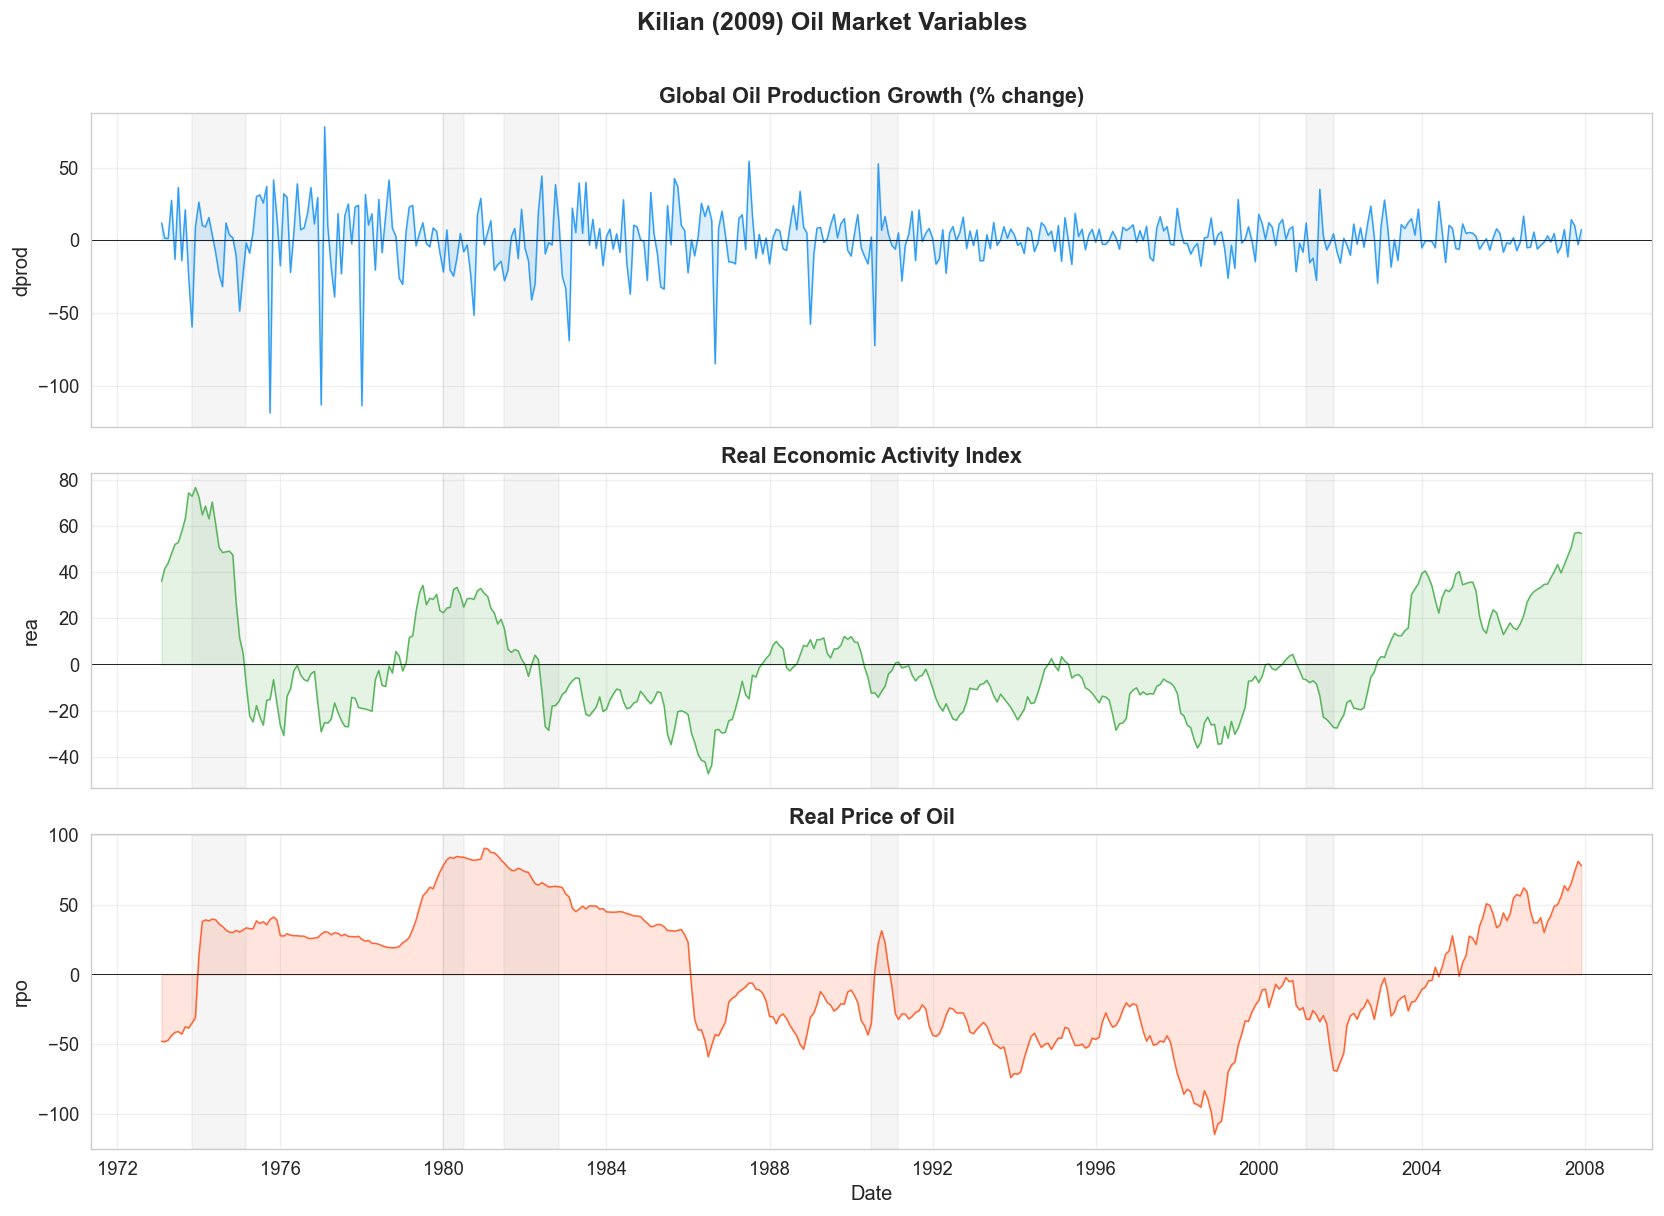

Grey shaded areas = approximate NBER recession periods.


In [13]:
# ── Individual time series ───────────────────────────────────
fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

variables = ['dprod', 'rea', 'rpo']
titles = [
    'Global Oil Production Growth (% change)',
    'Real Economic Activity Index',
    'Real Price of Oil'
]
colors = ['#2196F3', '#4CAF50', '#FF5722']

for ax, var, title, color in zip(axes, variables, titles, colors):
    ax.plot(df.index, df[var], color=color, linewidth=0.9, alpha=0.9)
    ax.fill_between(df.index, 0, df[var], alpha=0.15, color=color)
    ax.axhline(y=0, color='black', linewidth=0.5, linestyle='-')
    ax.set_title(title, fontweight='bold')
    ax.set_ylabel(var)
    # Shade NBER recessions (approximate)
    for start, end in [('1973-11','1975-03'), ('1980-01','1980-07'),
                        ('1981-07','1982-11'), ('1990-07','1991-03'),
                        ('2001-03','2001-11')]:
        ax.axvspan(pd.Timestamp(start), pd.Timestamp(end),
                   alpha=0.08, color='grey')

axes[-1].set_xlabel('Date')
fig.suptitle('Kilian (2009) Oil Market Variables', fontsize=15, fontweight='bold', y=1.01)
plt.tight_layout()
plt.savefig('fig01_timeseries.png', dpi=150, bbox_inches='tight')
plt.show()
print("Grey shaded areas = approximate NBER recession periods.")

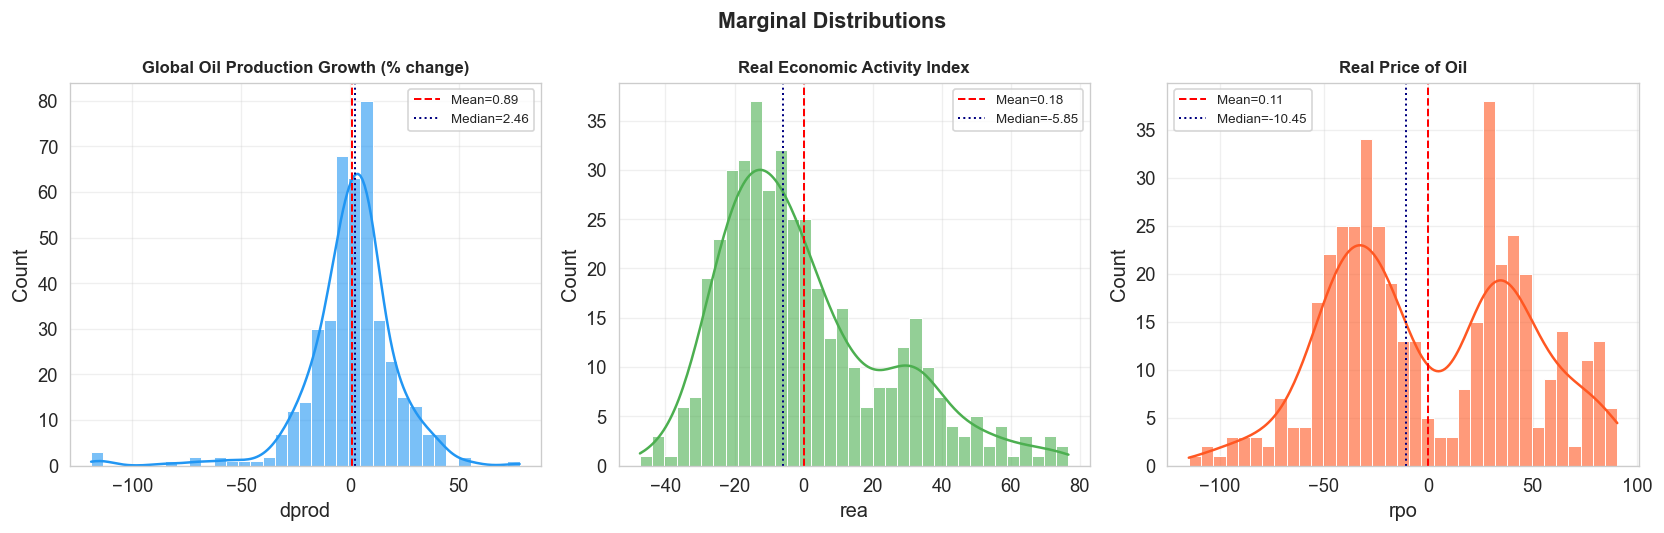

In [14]:
# ── Distributions & boxplots ─────────────────────────────────
fig, axes = plt.subplots(1, 3, figsize=(14, 4.5))

for ax, var, title, color in zip(axes, variables, titles, colors):
    sns.histplot(df[var], kde=True, ax=ax, color=color, alpha=0.6, bins=35)
    ax.axvline(df[var].mean(), color='red', linestyle='--', linewidth=1.2, label=f'Mean={df[var].mean():.2f}')
    ax.axvline(df[var].median(), color='navy', linestyle=':', linewidth=1.2, label=f'Median={df[var].median():.2f}')
    ax.set_title(title, fontweight='bold', fontsize=10)
    ax.legend(fontsize=8)

plt.suptitle('Marginal Distributions', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('fig02_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

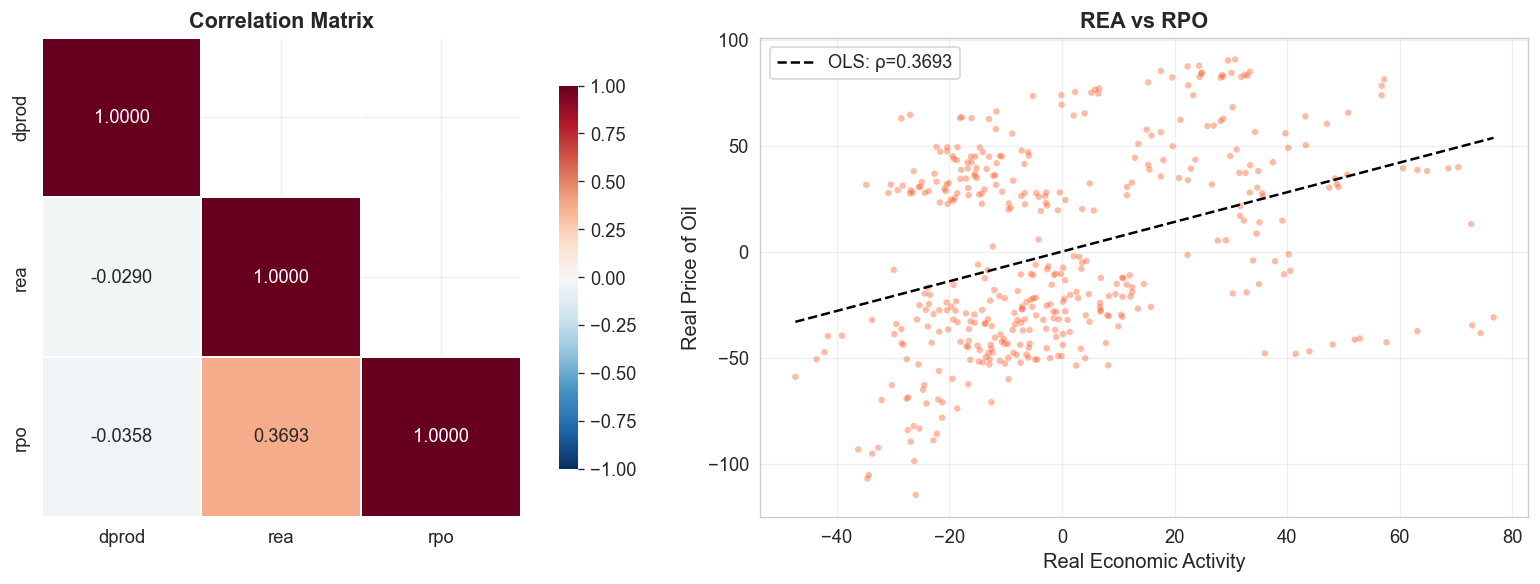

In [15]:
# ── Correlation heatmap & scatter matrix ─────────────────────
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Heatmap
mask = np.triu(np.ones_like(corr, dtype=bool), k=1)
sns.heatmap(corr, annot=True, fmt='.4f', cmap='RdBu_r', center=0,
            vmin=-1, vmax=1, ax=axes[0], square=True, mask=mask,
            linewidths=1, cbar_kws={'shrink': 0.8})
axes[0].set_title('Correlation Matrix', fontweight='bold')

# Scatter: rea vs rpo (highest correlation)
axes[1].scatter(df['rea'], df['rpo'], alpha=0.4, s=15, c='#FF5722', edgecolor='none')
z = np.polyfit(df['rea'], df['rpo'], 1)
p = np.poly1d(z)
x_line = np.linspace(df['rea'].min(), df['rea'].max(), 100)
axes[1].plot(x_line, p(x_line), 'k--', linewidth=1.5, label=f'OLS: ρ={corr.loc["rea","rpo"]:.4f}')
axes[1].set_xlabel('Real Economic Activity')
axes[1].set_ylabel('Real Price of Oil')
axes[1].set_title('REA vs RPO', fontweight='bold')
axes[1].legend()

plt.tight_layout()
plt.savefig('fig03_correlations.png', dpi=150, bbox_inches='tight')
plt.show()

## 4. Cumulated Series (Level Variables)

Kilian's variables are in first-differences / stationary form. For cointegration analysis we also examine the **cumulated** (level) series, which are I(1) by construction:

$$\text{dprod\_cum}_t = \sum_{s=1}^{t} \Delta\text{prod}_s, \qquad \text{rea\_cum}_t = \sum_{s=1}^{t} \text{rea}_s, \qquad \text{rpo\_cum}_t = \sum_{s=1}^{t} \text{rpo}_s$$

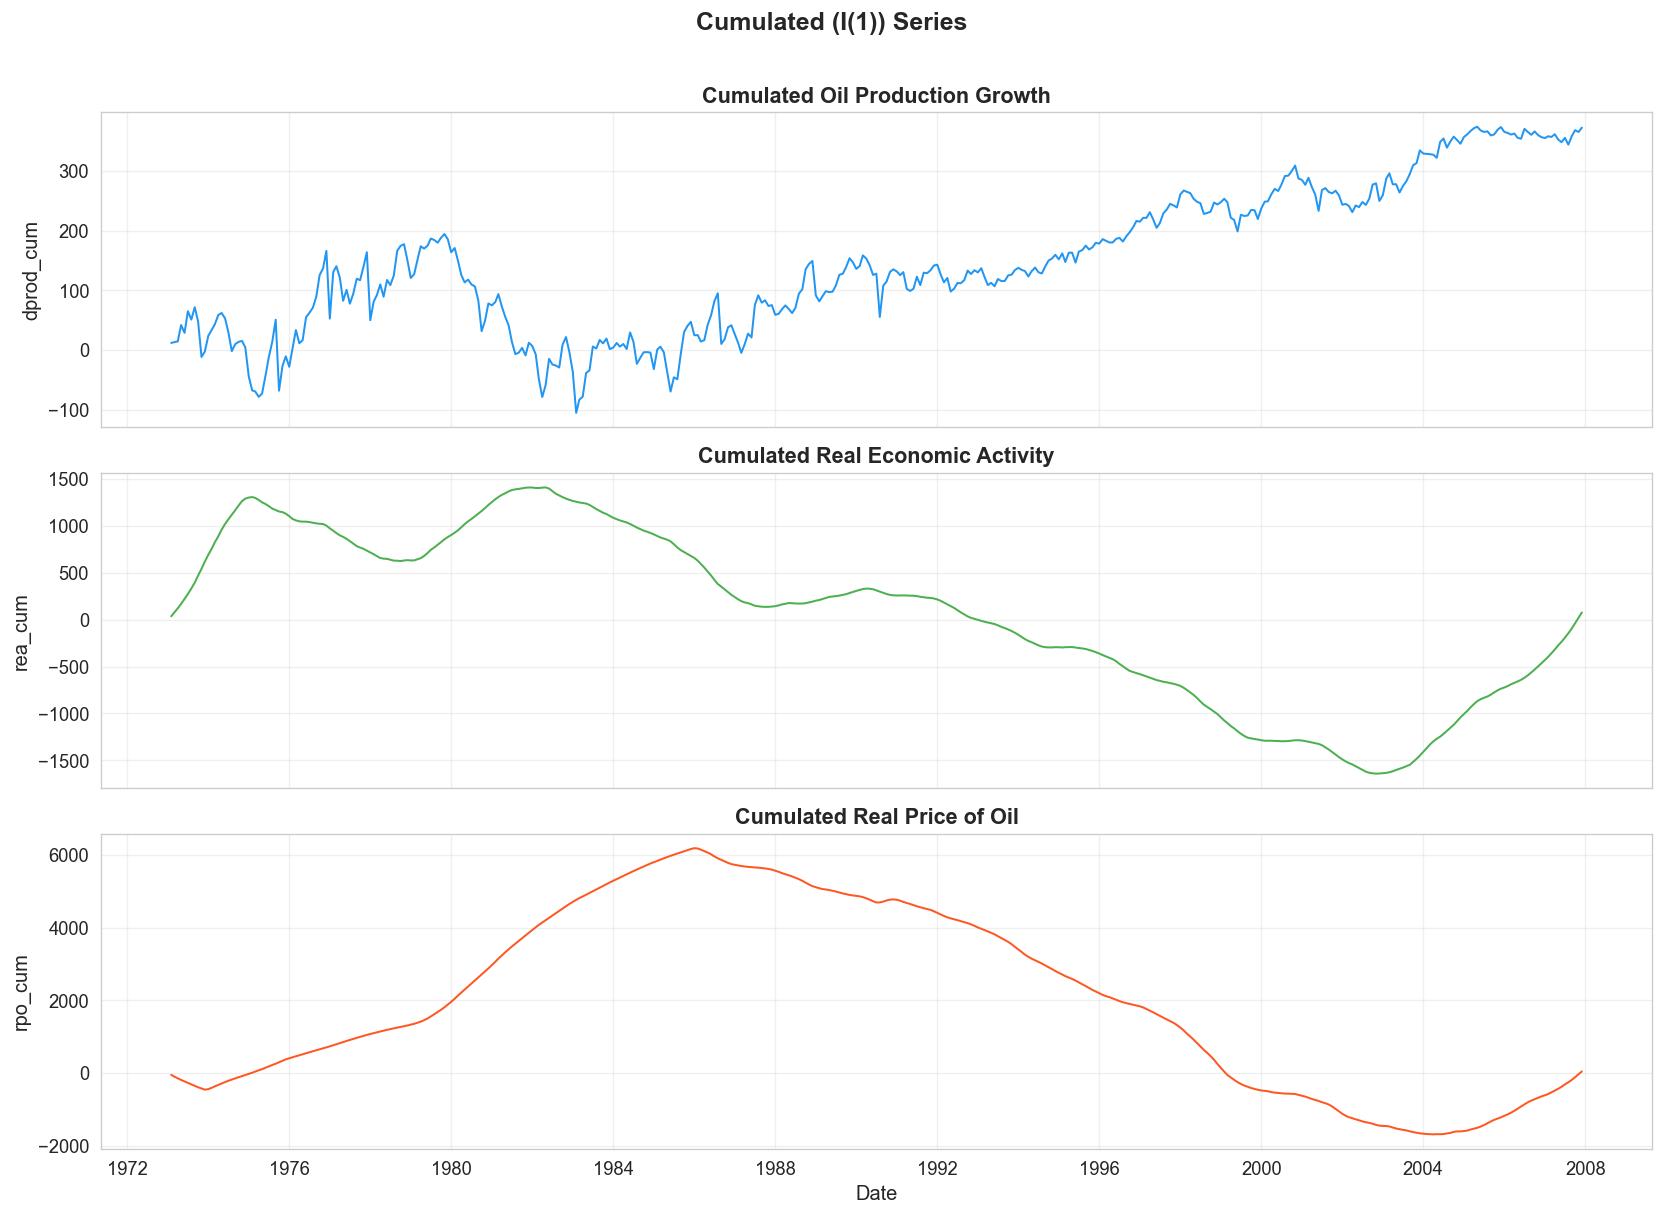

In [16]:
# ── Cumulated (level) series ─────────────────────────────────
df['dprod_cum'] = np.cumsum(df['dprod'].values)
df['rea_cum']   = np.cumsum(df['rea'].values)
df['rpo_cum']   = np.cumsum(df['rpo'].values)

fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)
cum_vars   = ['dprod_cum', 'rea_cum', 'rpo_cum']
cum_titles = ['Cumulated Oil Production Growth',
              'Cumulated Real Economic Activity',
              'Cumulated Real Price of Oil']

for ax, var, title, color in zip(axes, cum_vars, cum_titles, colors):
    ax.plot(df.index, df[var], color=color, linewidth=1.2)
    ax.set_title(title, fontweight='bold')
    ax.set_ylabel(var)

axes[-1].set_xlabel('Date')
fig.suptitle('Cumulated (I(1)) Series', fontsize=15, fontweight='bold', y=1.01)
plt.tight_layout()
plt.savefig('fig04_cumulated.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 5. Segmented Cointegration Tests

### 5.1 Theoretical Background

Standard cointegration tests assume the cointegrating relationship holds over the **entire sample**. However, the relationship may only hold during certain sub-periods (regimes) and break down temporarily. Kim (2003) formalises this as **segmented cointegration**:

$$x_{1t} = \alpha + \beta' x_{2t} + \varepsilon_t$$

where $\varepsilon_t$ has autoregressive root $\rho_t$:

$$\rho_t = \begin{cases} \rho < 1 & \text{if } t \in C_T \text{ (cointegration period)} \\ 1 & \text{if } t \in N_T \text{ (non-cointegration period)} \end{cases}$$

We apply two complementary test procedures:

| Test | Null Hypothesis | Alternative | Key Statistics |
|------|----------------|-------------|----------------|
| **Kim (2003)** | $H_0$: $\rho = 1$ for all $t$ | $H_1$: segmented coint. | $Z^*_\rho$, $Z^*_t$, $ADF^*_\rho$, $ADF^*_t$ |
| **Martins & Rodrigues (2022)** | $H_0$: no cointegration | $H_1$: $m^*$ breaks | $W(m^*)$, $W_{\max}$ |

### 5.2 Test Configurations

In [17]:
# ── Define all test configurations ───────────────────────────
# We test multiple specifications systematically

configs = [
    # (label, y_col, X_cols, use_cum, model)
    ("A: rpo ~ rea",             'rpo',     ['rea'],          False, 'drift'),
    ("B: rpo ~ dprod",           'rpo',     ['dprod'],        False, 'drift'),
    ("C: rpo ~ dprod + rea",     'rpo',     ['dprod', 'rea'], False, 'drift'),
    ("D: rpo_cum ~ rea_cum",     'rpo_cum', ['rea_cum'],      True,  'drift'),
    ("E: rpo_cum ~ dprod_cum",   'rpo_cum', ['dprod_cum'],    True,  'drift'),
    ("F: rpo_cum ~ dprod_cum + rea_cum",
                                 'rpo_cum', ['dprod_cum', 'rea_cum'], True, 'drift'),
]

print(tabulate(
    [[c[0], c[1], ' + '.join(c[2]), 'Cumulated' if c[3] else 'Raw', c[4]]
     for c in configs],
    headers=['Config', 'Dependent (y)', 'Regressors (X)', 'Type', 'Model'],
    tablefmt='fancy_grid', showindex=False
))

╒══════════════════════════════════╤═════════════════╤═════════════════════╤═══════════╤═════════╕
│ Config                           │ Dependent (y)   │ Regressors (X)      │ Type      │ Model   │
╞══════════════════════════════════╪═════════════════╪═════════════════════╪═══════════╪═════════╡
│ A: rpo ~ rea                     │ rpo             │ rea                 │ Raw       │ drift   │
├──────────────────────────────────┼─────────────────┼─────────────────────┼───────────┼─────────┤
│ B: rpo ~ dprod                   │ rpo             │ dprod               │ Raw       │ drift   │
├──────────────────────────────────┼─────────────────┼─────────────────────┼───────────┼─────────┤
│ C: rpo ~ dprod + rea             │ rpo             │ dprod + rea         │ Raw       │ drift   │
├──────────────────────────────────┼─────────────────┼─────────────────────┼───────────┼─────────┤
│ D: rpo_cum ~ rea_cum             │ rpo_cum         │ rea_cum             │ Cumulated │ drift   │
├─────────

### 5.3 Kim (2003) — Infimum-Based Tests

The Kim (2003) procedure searches over all admissible segmentations $N_T$ of length $\leq \bar{\ell}(T_N) \cdot T$ and computes the **infimum** of four test statistics over the cointegration subset $C_T = \{1,...,T\} \setminus N_T$:

$$Z^*_\rho = \inf_{C_T} Z_\rho(C_T), \quad Z^*_t = \inf_{C_T} Z_t(C_T)$$
$$ADF^*_\rho = \inf_{C_T} ADF_\rho(C_T), \quad ADF^*_t = \inf_{C_T} ADF_t(C_T)$$

Critical values are from Kim (2003, Tables 1–2) with $\bar{\ell}(T_N) = 0.30$.

In [18]:
# ── Run Kim (2003) tests for all configurations ──────────────
kim_results = {}

for label, y_col, x_cols, _, model in configs:
    y = df[y_col].values
    X = df[x_cols].values if len(x_cols) > 1 else df[x_cols[0]].values.reshape(-1, 1)
    
    print(f"▸ Running Kim test: {label} ...", end=" ", flush=True)
    res = kim_test(y, X, model=model, max_ell=0.3, step=2)
    kim_results[label] = res
    print("done")

print("\n✓ All Kim (2003) tests completed.")

▸ Running Kim test: A: rpo ~ rea ... done
▸ Running Kim test: B: rpo ~ dprod ... done
▸ Running Kim test: C: rpo ~ dprod + rea ... done
▸ Running Kim test: D: rpo_cum ~ rea_cum ... done
▸ Running Kim test: E: rpo_cum ~ dprod_cum ... done
▸ Running Kim test: F: rpo_cum ~ dprod_cum + rea_cum ... done

✓ All Kim (2003) tests completed.


In [19]:
# ── Kim (2003) — Summary Table of All Configurations ────────
rows_table = []
for label, res in kim_results.items():
    for stat in ['Zp', 'Zt', 'ADFp', 'ADFt']:
        val = res.infimum_stats[stat]
        cv5 = res.critical_values[stat][0.05]
        sig = '**' if res.significant(stat, 0.05) else (
              '*'  if res.significant(stat, 0.10) else '')
        t0, t1 = res.break_fractions(stat)
        rows_table.append([
            label, stat, f"{val:.4f}", f"{cv5:.4f}", sig,
            f"({t0:.3f}, {t1:.3f})"
        ])

print(tabulate(
    rows_table,
    headers=['Config', 'Stat', 'Inf. Value', '5% CV', 'Sig.', 'Break (τ₀, τ₁)'],
    tablefmt='fancy_grid', showindex=False
))
print("\nNotes: ** p < 0.05, * p < 0.10")

╒══════════════════════════════════╤════════╤══════════════╤═════════╤════════╤══════════════════╕
│ Config                           │ Stat   │   Inf. Value │   5% CV │ Sig.   │ Break (τ₀, τ₁)   │
╞══════════════════════════════════╪════════╪══════════════╪═════════╪════════╪══════════════════╡
│ A: rpo ~ rea                     │ Zp     │     -16.5547 │  -50.75 │        │ (0.205, 0.356)   │
├──────────────────────────────────┼────────┼──────────────┼─────────┼────────┼──────────────────┤
│ A: rpo ~ rea                     │ Zt     │      -3.0007 │   -6.36 │        │ (0.205, 0.356)   │
├──────────────────────────────────┼────────┼──────────────┼─────────┼────────┼──────────────────┤
│ A: rpo ~ rea                     │ ADFp   │     -16.3362 │  -50.75 │        │ (0.095, 0.360)   │
├──────────────────────────────────┼────────┼──────────────┼─────────┼────────┼──────────────────┤
│ A: rpo ~ rea                     │ ADFt   │      -2.8365 │   -6.36 │        │ (0.095, 0.360)   │
├─────────

In [20]:
# ── Kim (2003) — Detailed Results for Key Specifications ────
for label in ["C: rpo ~ dprod + rea", "F: rpo_cum ~ dprod_cum + rea_cum"]:
    res = kim_results[label]
    print("═" * 70)
    print(res.summary())
    print()

══════════════════════════════════════════════════════════════════════
Kim (2003) Segmented Cointegration Test Results
Model:            Case II (intercept)
Sample size (T):  419
Variables (n):    3
Max ell (T_N):    0.30
ADF lag order:    12

------------------------------------------------------------------------
Statistic      Inf. Value  Full Sample       5% CV  Reject H0     tau_0    tau_1
------------------------------------------------------------------------
Zp*              -16.6549     -10.9193    -65.5300         No     0.205    0.356
Zt*               -3.0060      -2.4623     -7.3800         No     0.205    0.356
ADFp*            -16.1741     -10.3283    -65.5300         No     0.177    0.360
ADFt*             -2.8040      -2.0346     -7.3800         No     0.558    0.742
------------------------------------------------------------------------
Notes: Infimum statistics are Z*_rho, Z*_t, ADF*_rho, ADF*_t
       from Kim (2003, Eqs. 3.13-3.14).
       Critical values from Tab

### 5.4 Martins & Rodrigues (2022) — Wald-Type Tests

The MR (2022) procedure uses **sup-Wald-type** statistics to test for segmented cointegration with $m^*$ structural breaks. Two hypotheses are considered:

- **$H_{1A}$**: First regime is $I(1)$ → switches to $I(0)$ → back to $I(1)$ → ...
- **$H_{1B}$**: First regime is $I(0)$ → switches to $I(1)$ → back to $I(0)$ → ...

$$W(m^*) = \max\{\sup F_A(m^*),\; \sup F_B(m^*)\}, \qquad W_{\max} = \max_{1 \leq m \leq \bar{m}} W(m)$$

Trimming parameter $\varepsilon = 0.15$ ensures each regime has at least $15\%$ of the sample.

In [21]:
# ── Run Martins & Rodrigues (2022) tests ─────────────────────
mr_results = {}

for label, y_col, x_cols, _, model in configs:
    y = df[y_col].values
    X = df[x_cols].values if len(x_cols) > 1 else df[x_cols[0]].values.reshape(-1, 1)
    
    print(f"▸ Running MR test: {label} ...", end=" ", flush=True)
    res = mr_test(y, X, model=model, max_breaks=3, epsilon=0.15, step=2)
    mr_results[label] = res
    print("done")

print("\n✓ All Martins & Rodrigues (2022) tests completed.")

▸ Running MR test: A: rpo ~ rea ... done
▸ Running MR test: B: rpo ~ dprod ... done
▸ Running MR test: C: rpo ~ dprod + rea ... done
▸ Running MR test: D: rpo_cum ~ rea_cum ... done
▸ Running MR test: E: rpo_cum ~ dprod_cum ... done
▸ Running MR test: F: rpo_cum ~ dprod_cum + rea_cum ... done

✓ All Martins & Rodrigues (2022) tests completed.


In [22]:
# ── MR (2022) — Summary Table of All Configurations ────────
rows_mr = []
for label, res in mr_results.items():
    for m in sorted(res.W_stats.keys()):
        w_val = res.W_stats[m]
        cv5 = res.critical_values.get(m, {}).get(0.05, float('nan'))
        cv10 = res.critical_values.get(m, {}).get(0.10, float('nan'))
        sig = '**' if w_val > cv5 else ('*' if w_val > cv10 else '')
        rows_mr.append([label, f"W({m})", f"{w_val:.4f}", f"{cv5:.4f}", sig])
    
    # W_max
    cv5_wmax = res.critical_values.get('Wmax', {}).get(0.05, float('nan'))
    cv10_wmax = res.critical_values.get('Wmax', {}).get(0.10, float('nan'))
    sig_wmax = '**' if res.W_max > cv5_wmax else ('*' if res.W_max > cv10_wmax else '')
    rows_mr.append([label, f"W_max", f"{res.W_max:.4f}", f"{cv5_wmax:.4f}", sig_wmax])
    rows_mr.append(['', '', '', '', ''])

print(tabulate(
    rows_mr,
    headers=['Config', 'Test', 'Statistic', '5% CV', 'Sig.'],
    tablefmt='fancy_grid', showindex=False
))
print("\nNotes: ** p < 0.05, * p < 0.10")

╒══════════════════════════════════╤════════╤═════════════╤═════════╤════════╕
│ Config                           │ Test   │ Statistic   │ 5% CV   │ Sig.   │
╞══════════════════════════════════╪════════╪═════════════╪═════════╪════════╡
│ A: rpo ~ rea                     │ W(1)   │ 5.9991      │ 9.1060  │        │
├──────────────────────────────────┼────────┼─────────────┼─────────┼────────┤
│ A: rpo ~ rea                     │ W(2)   │ 12.9595     │ 9.2770  │ **     │
├──────────────────────────────────┼────────┼─────────────┼─────────┼────────┤
│ A: rpo ~ rea                     │ W(3)   │ 8.5779      │ 7.7640  │ **     │
├──────────────────────────────────┼────────┼─────────────┼─────────┼────────┤
│ A: rpo ~ rea                     │ W_max  │ 12.9595     │ nan     │        │
├──────────────────────────────────┼────────┼─────────────┼─────────┼────────┤
│                                  │        │             │         │        │
├──────────────────────────────────┼────────┼───────

In [23]:
# ── MR (2022) — Detailed results for key specifications ─────
for label in ["C: rpo ~ dprod + rea", "F: rpo_cum ~ dprod_cum + rea_cum"]:
    res = mr_results[label]
    print("═" * 72)
    print(res.summary())
    print()

════════════════════════════════════════════════════════════════════════
Martins & Rodrigues (2022) Wald-Type Tests for Segmented Cointegration
Model:            Intercept only
Sample size (T):  419
Variables (K+1):  3
Trimming (eps):   0.15
Max breaks:       3
ADF lag order:    12

------------------------------------------------------------------------------
Test          Statistic      10% CV      5% CV      1% CV   Reject 5%
------------------------------------------------------------------------------
W(1)           6.0862       7.711      8.761     11.103          No
W(2)          12.4415       8.036      9.090     11.470       Yes**
W(3)           8.3917       6.830      7.645      9.855       Yes**
W_max          12.4415       9.214     10.552     13.973       Yes**
------------------------------------------------------------------------------

Estimated break dates (for W_max):
  Number of breaks:  2
  First regime:      I(1) (H1A)
  Break dates:       (143, 350)
  Break fract

---
## 6. Estimated Break Dates

When segmented cointegration is detected, the estimated **structural break dates** divide the sample into regimes of cointegration and non-cointegration. We map observation indices back to calendar dates.

In [24]:
# ── Estimated break dates from MR (2022) ────────────────────
break_table = []
for label, res in mr_results.items():
    m_star = res.W_max_m
    if m_star in res.best_breaks:
        breaks = res.best_breaks[m_star]['breaks']
        hyp = res.best_breaks[m_star].get('hypothesis', 'N/A')
        break_dates_str = []
        for b in breaks:
            if b < len(df):
                break_dates_str.append(df.index[b].strftime('%Y:%m'))
            else:
                break_dates_str.append(f"obs {b}")
        fracs = [f"{b/T:.3f}" for b in breaks]
        break_table.append([
            label, m_star, hyp,
            ', '.join(break_dates_str),
            ', '.join(fracs),
            f"{res.W_max:.4f}"
        ])

print(tabulate(
    break_table,
    headers=['Config', 'm*', 'Hyp', 'Break Dates', 'Fractions', 'W_max'],
    tablefmt='fancy_grid', showindex=False
))

╒══════════════════════════════════╤══════╤═══════╤═══════════════════════════╤═════════════════════╤═════════╕
│ Config                           │   m* │ Hyp   │ Break Dates               │ Fractions           │   W_max │
╞══════════════════════════════════╪══════╪═══════╪═══════════════════════════╪═════════════════════╪═════════╡
│ A: rpo ~ rea                     │    2 │ A     │ 1985:01, 2002:04          │ 0.341, 0.835        │ 12.9595 │
├──────────────────────────────────┼──────┼───────┼───────────────────────────┼─────────────────────┼─────────┤
│ B: rpo ~ dprod                   │    3 │ B     │ 1978:05, 1985:02, 1990:09 │ 0.150, 0.344, 0.504 │ 15.8329 │
├──────────────────────────────────┼──────┼───────┼───────────────────────────┼─────────────────────┼─────────┤
│ C: rpo ~ dprod + rea             │    2 │ A     │ 1985:01, 2002:04          │ 0.341, 0.835        │ 12.4415 │
├──────────────────────────────────┼──────┼───────┼───────────────────────────┼─────────────────────┼───

In [25]:
# ── Kim (2003) Break Estimator (Extremum) ────────────────────
print("Kim (2003) Extremum Break Estimator: argmax Λ_T(τ)")
print("─" * 60)

kim_break_table = []
for label, y_col, x_cols, _, model in configs:
    y = df[y_col].values
    X = df[x_cols].values if len(x_cols) > 1 else df[x_cols[0]].values.reshape(-1, 1)
    
    be = kim_break_estimator(y, X, model=model, step=2)
    t0, t1 = be['tau_hat']
    k0, k1 = be['k0_hat'], be['k1_hat']
    lam = be['Lambda_max']
    
    d0 = df.index[k0].strftime('%Y:%m') if k0 < len(df) else f"obs {k0}"
    d1 = df.index[min(k1, len(df)-1)].strftime('%Y:%m')
    
    kim_break_table.append([label, f"({t0:.3f}, {t1:.3f})", f"({d0}, {d1})", f"{lam:.4f}"])

print(tabulate(
    kim_break_table,
    headers=['Config', '(τ̂₀, τ̂₁)', 'Break Dates', 'Λ_max'],
    tablefmt='fancy_grid', showindex=False
))

Kim (2003) Extremum Break Estimator: argmax Λ_T(τ)
────────────────────────────────────────────────────────────
╒══════════════════════════════════╤════════════════╤════════════════════╤═════════╕
│ Config                           │ (τ̂₀, τ̂₁)       │ Break Dates        │   Λ_max │
╞══════════════════════════════════╪════════════════╪════════════════════╪═════════╡
│ A: rpo ~ rea                     │ (0.740, 0.742) │ (1998:12, 1999:01) │  5.3014 │
├──────────────────────────────────┼────────────────┼────────────────────┼─────────┤
│ B: rpo ~ dprod                   │ (0.740, 0.742) │ (1998:12, 1999:01) │  6.5067 │
├──────────────────────────────────┼────────────────┼────────────────────┼─────────┤
│ C: rpo ~ dprod + rea             │ (0.740, 0.742) │ (1998:12, 1999:01) │  5.336  │
├──────────────────────────────────┼────────────────┼────────────────────┼─────────┤
│ D: rpo_cum ~ rea_cum             │ (0.053, 0.055) │ (1974:12, 1975:01) │  3.855  │
├──────────────────────────────────┼

## 7. Visualisation of Regime Breaks

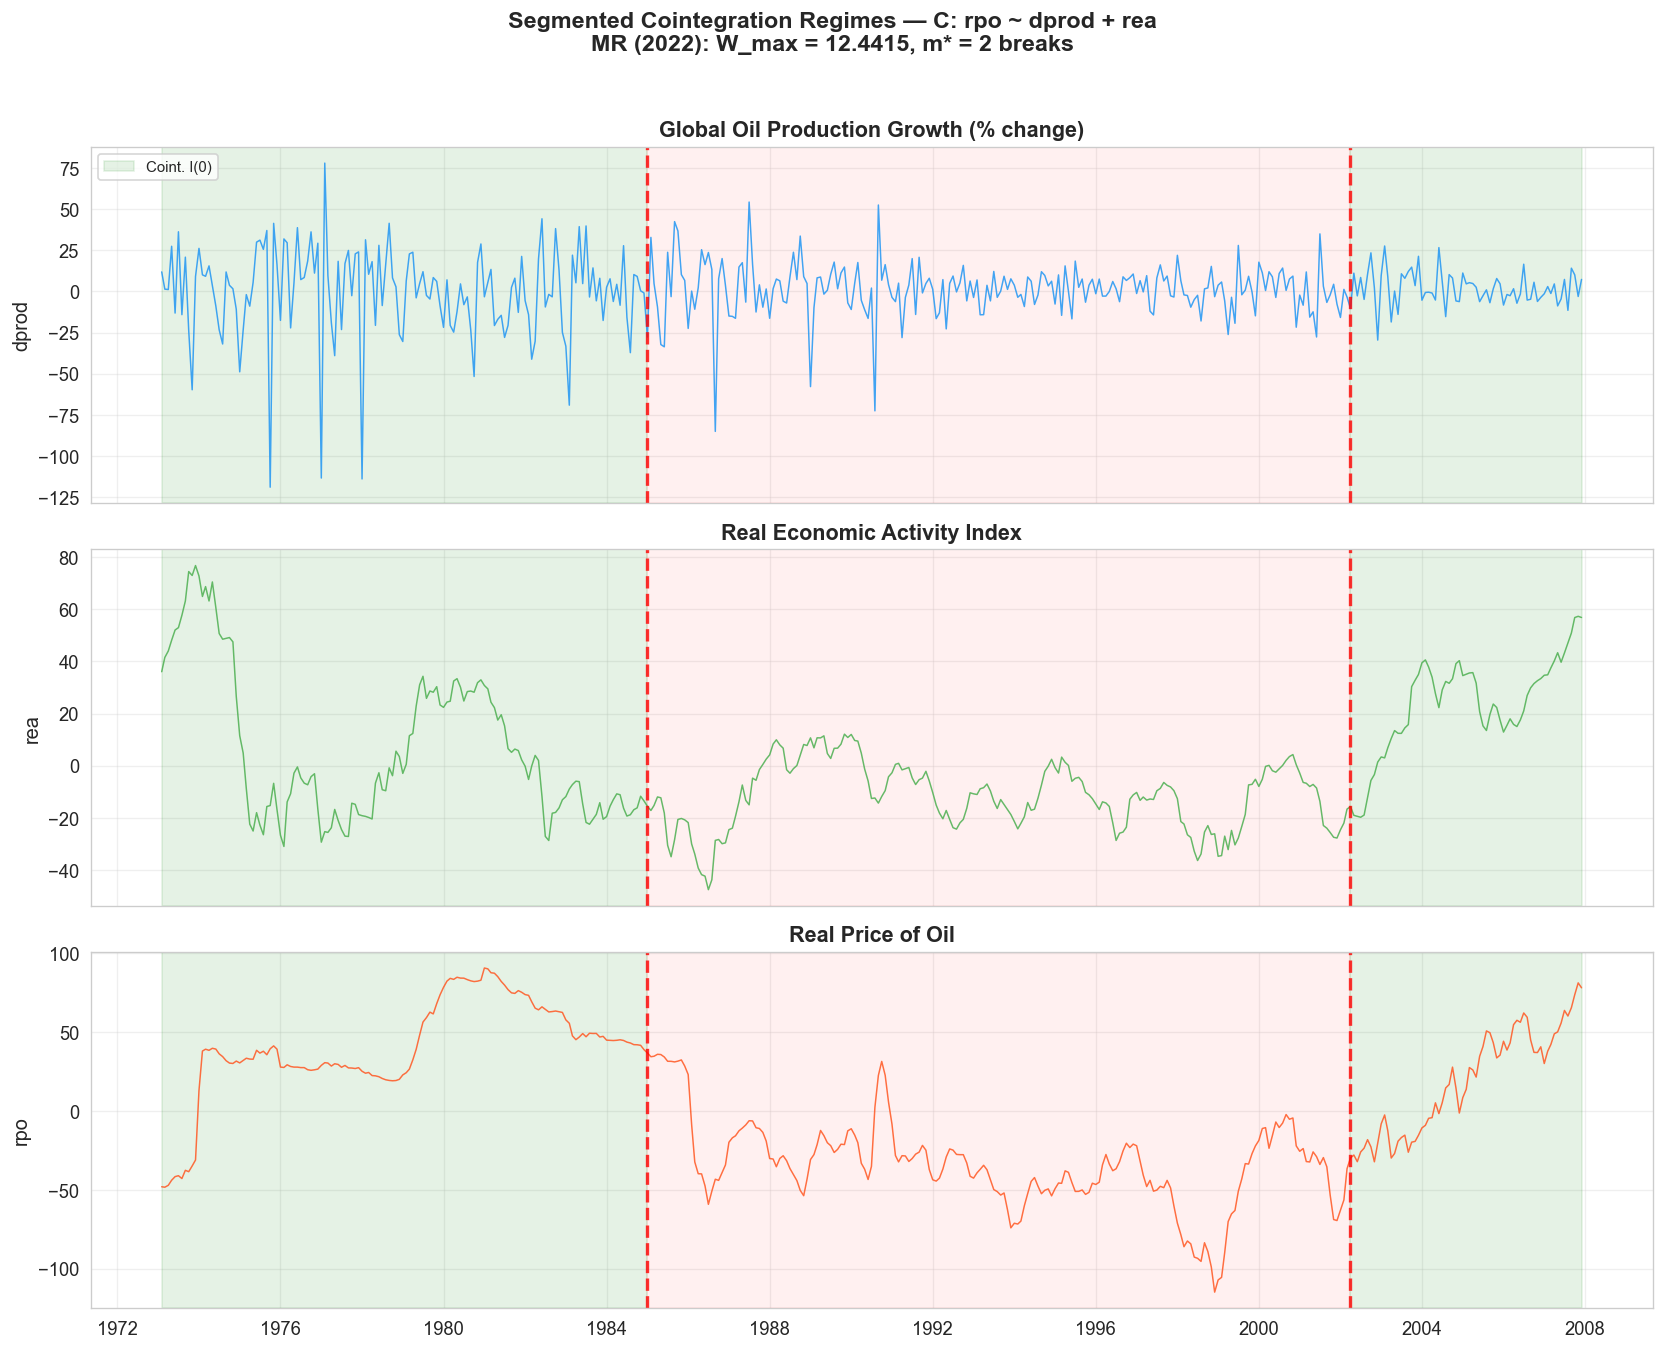


MR (2022) Estimated Regimes:
╒══════════╤═════════╤═════════╤═══════╤═════════════════════════╕
│ Regime   │ Start   │ End     │   Obs │ Type                    │
╞══════════╪═════════╪═════════╪═══════╪═════════════════════════╡
│ Regime 1 │ 1973:02 │ 1985:01 │   144 │ I(0) — Cointegration    │
├──────────┼─────────┼─────────┼───────┼─────────────────────────┤
│ Regime 2 │ 1985:01 │ 2002:04 │   208 │ I(1) — No cointegration │
├──────────┼─────────┼─────────┼───────┼─────────────────────────┤
│ Regime 3 │ 2002:04 │ 2007:12 │    69 │ I(0) — Cointegration    │
╘══════════╧═════════╧═════════╧═══════╧═════════════════════════╛


In [44]:
# ── Regime plot: rpo ~ dprod + rea (Config C) ────────────────
label = "C: rpo ~ dprod + rea"
res_mr_c = mr_results[label]
res_kim_c = kim_results[label]

fig, axes = plt.subplots(3, 1, figsize=(14, 11), sharex=True)

for ax, var, title, color in zip(axes, variables, titles, colors):
    ax.plot(df.index, df[var], color=color, linewidth=0.9, alpha=0.85)
    ax.set_title(title, fontweight='bold')
    ax.set_ylabel(var)

# Add MR break dates
m_star = res_mr_c.W_max_m
if m_star in res_mr_c.best_breaks:
    breaks = res_mr_c.best_breaks[m_star]['breaks']
    hyp = res_mr_c.best_breaks[m_star].get('hypothesis', 'H1A')
    
    for b in breaks:
        if b < len(df):
            for ax in axes:
                ax.axvline(x=df.index[b], color='red', linewidth=2, linestyle='--', alpha=0.8)
    
    # Shade regimes
    all_bounds = [0] + list(breaks) + [T-1]
    is_I1 = (hyp == 'H1A')  # first regime is I(1) for H1A
    
    for i in range(len(all_bounds) - 1):
        start_idx = all_bounds[i]
        end_idx   = min(all_bounds[i+1], T-1)
        start_dt  = df.index[start_idx]
        end_dt    = df.index[end_idx]
        
        if is_I1:
            for ax in axes:
                ax.axvspan(start_dt, end_dt, alpha=0.06, color='red',
                          label='Non-coint. I(1)' if i == 0 else '')
        else:
            for ax in axes:
                ax.axvspan(start_dt, end_dt, alpha=0.10, color='green',
                          label='Coint. I(0)' if i == 0 else '')
        is_I1 = not is_I1

axes[0].legend(loc='upper left', fontsize=9)

fig.suptitle(f'Segmented Cointegration Regimes — {label}\n'
             f'MR (2022): W_max = {res_mr_c.W_max:.4f}, m* = {m_star} breaks',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('fig05_regimes_raw.png', dpi=150, bbox_inches='tight')
plt.show()

# Print regime details
print("\nMR (2022) Estimated Regimes:")
regime_rows = []
is_I1 = (hyp == 'H1A')
for i in range(len(all_bounds) - 1):
    s = all_bounds[i]; e = min(all_bounds[i+1], T-1)
    regime_rows.append([
        f"Regime {i+1}",
        df.index[s].strftime('%Y:%m'),
        df.index[e].strftime('%Y:%m'),
        e - s + 1,
        'I(1) — No cointegration' if is_I1 else 'I(0) — Cointegration'
    ])
    is_I1 = not is_I1

print(tabulate(regime_rows, headers=['Regime', 'Start', 'End', 'Obs', 'Type'],
               tablefmt='fancy_grid', showindex=False))

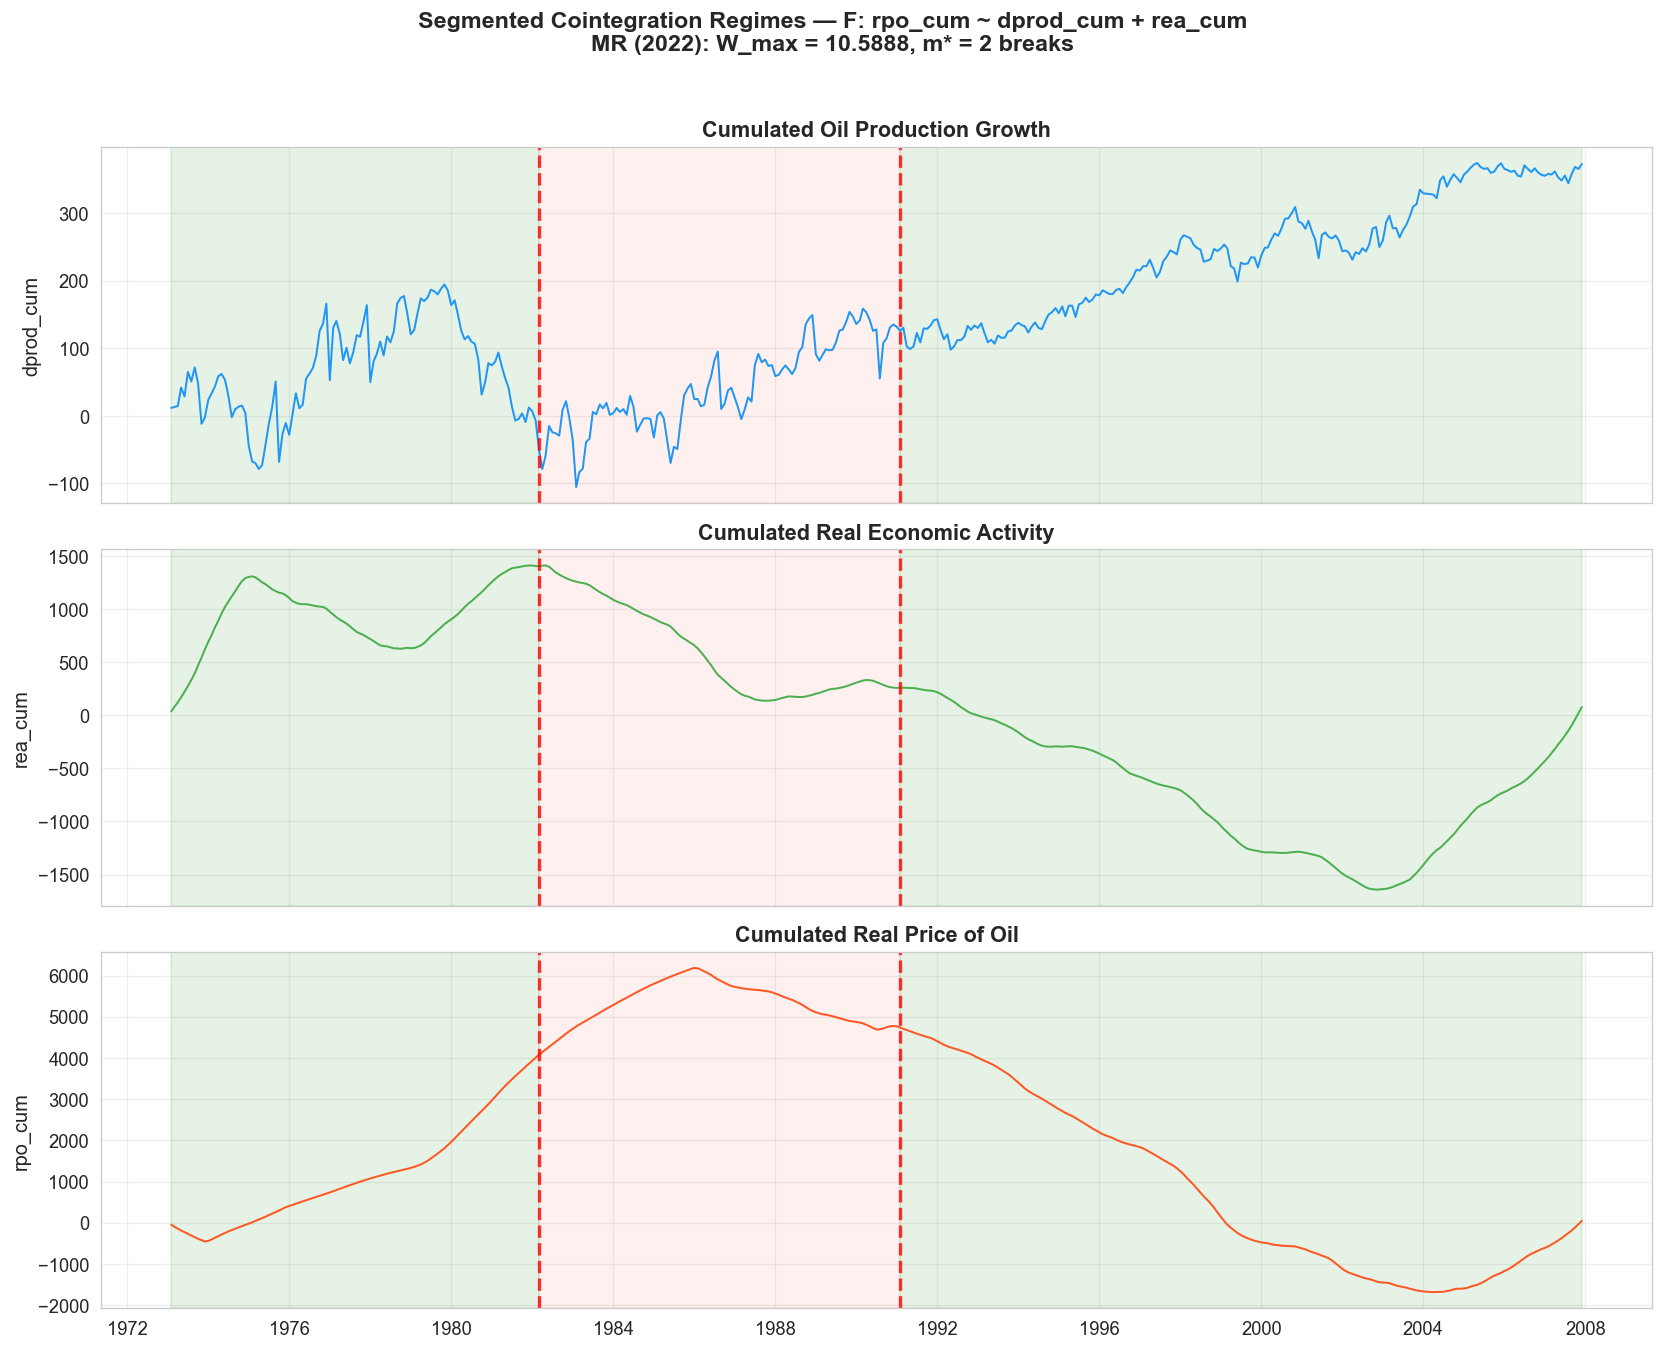

In [45]:
# ── Regime plot: rpo_cum ~ dprod_cum + rea_cum (Config F) ────
label_f = "F: rpo_cum ~ dprod_cum + rea_cum"
res_mr_f = mr_results[label_f]

fig, axes = plt.subplots(3, 1, figsize=(14, 11), sharex=True)

for ax, var, title, color in zip(axes, cum_vars, cum_titles, colors):
    ax.plot(df.index, df[var], color=color, linewidth=1.2)
    ax.set_title(title, fontweight='bold')
    ax.set_ylabel(var)

m_star_f = res_mr_f.W_max_m
if m_star_f in res_mr_f.best_breaks:
    breaks_f = res_mr_f.best_breaks[m_star_f]['breaks']
    hyp_f = res_mr_f.best_breaks[m_star_f].get('hypothesis', 'H1A')
    
    for b in breaks_f:
        if b < len(df):
            for ax in axes:
                ax.axvline(x=df.index[b], color='red', linewidth=2, linestyle='--', alpha=0.8)
    
    all_bounds_f = [0] + list(breaks_f) + [T-1]
    is_I1 = (hyp_f == 'H1A')
    for i in range(len(all_bounds_f) - 1):
        s = all_bounds_f[i]; e = min(all_bounds_f[i+1], T-1)
        if is_I1:
            for ax in axes:
                ax.axvspan(df.index[s], df.index[e], alpha=0.06, color='red')
        else:
            for ax in axes:
                ax.axvspan(df.index[s], df.index[e], alpha=0.10, color='green')
        is_I1 = not is_I1

fig.suptitle(f'Segmented Cointegration Regimes — {label_f}\n'
             f'MR (2022): W_max = {res_mr_f.W_max:.4f}, m* = {m_star_f} breaks',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('fig06_regimes_cum.png', dpi=150, bbox_inches='tight')
plt.show()

## 8. Cointegrating Residuals Analysis

Examining the OLS residuals from the cointegrating regression provides insight into the segmentation structure. Under segmented cointegration, the residuals should appear stationary in some periods and non-stationary in others.

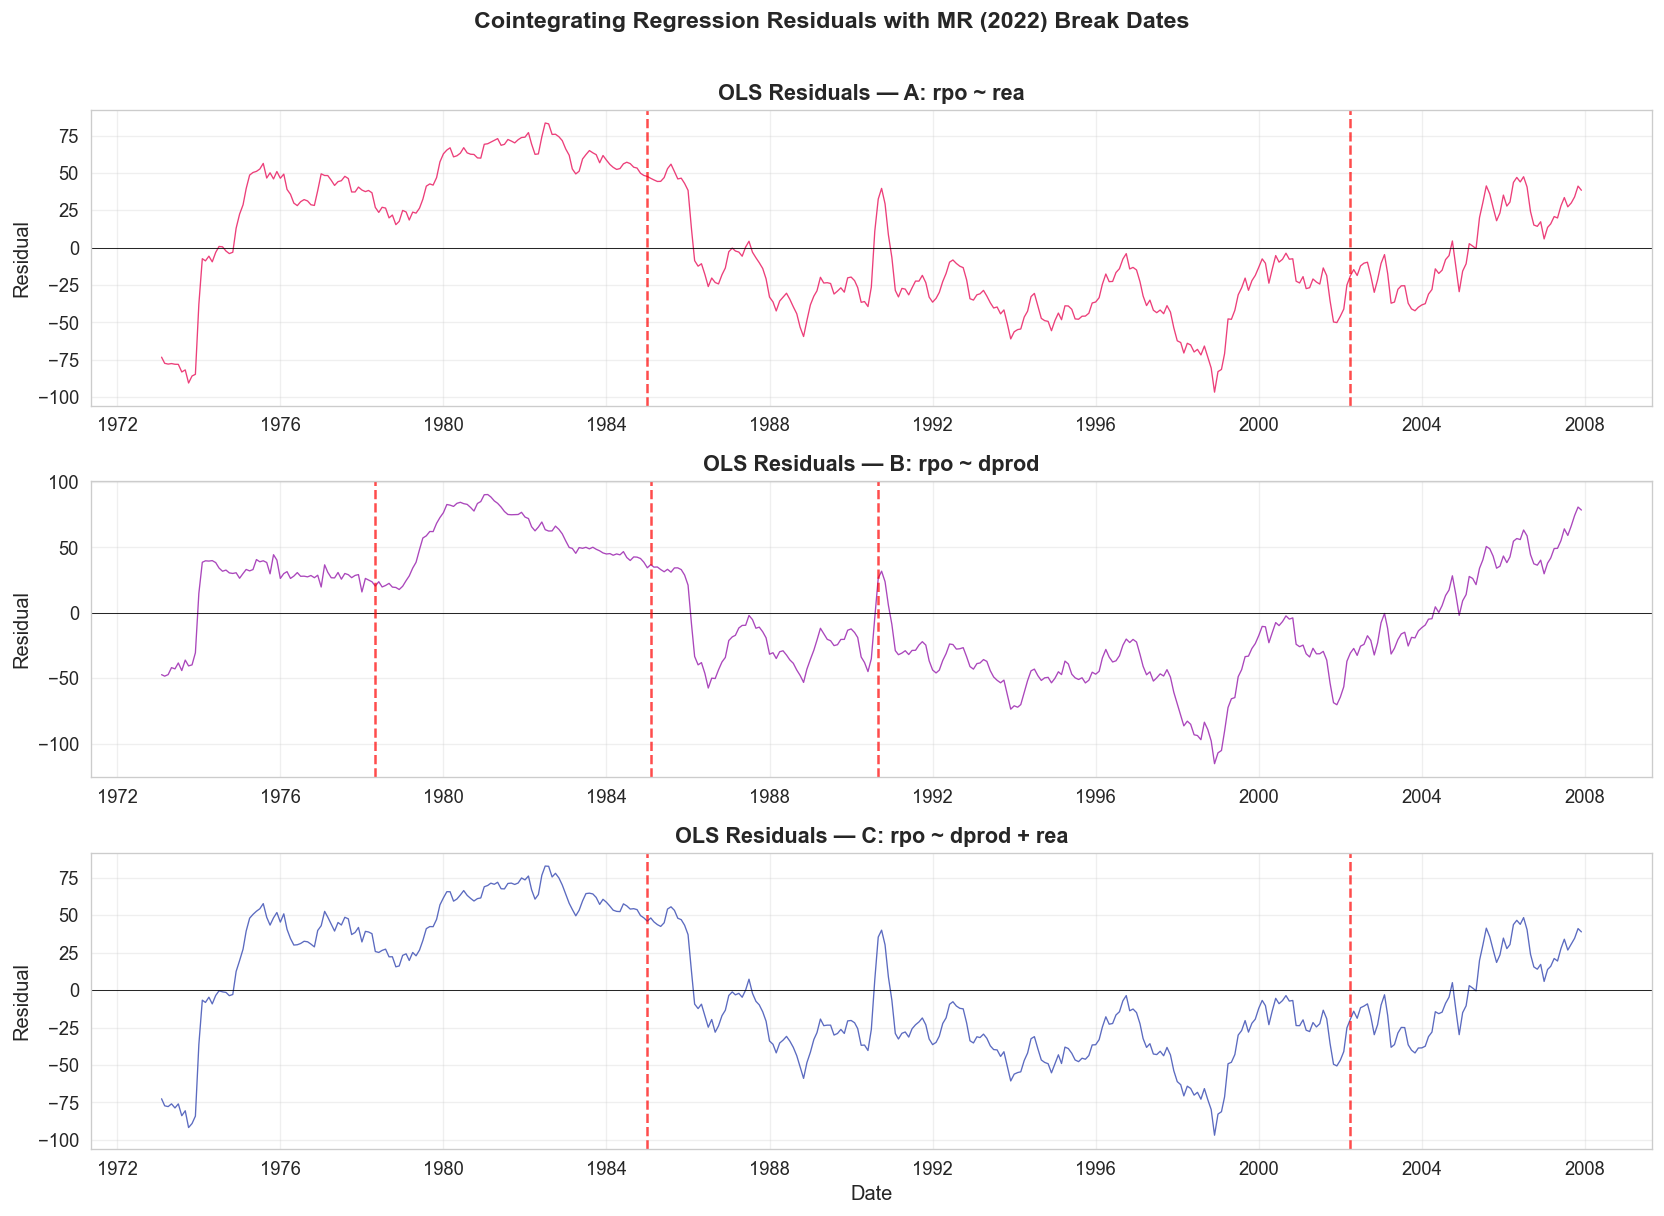

In [40]:
# ── OLS Residuals for all raw specifications ─────────────────
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

raw_configs = [c for c in configs if not c[3]]  # non-cumulated only
colors_res = ['#E91E63', '#9C27B0', '#3F51B5']

for ax, (label, y_col, x_cols, _, model), col in zip(axes, raw_configs, colors_res):
    y = df[y_col].values
    X = df[x_cols].values if len(x_cols) > 1 else df[x_cols[0]].values.reshape(-1, 1)
    residuals, _ = ols_residuals(y, X, model=model)
    
    ax.plot(df.index, residuals, color=col, linewidth=0.8, alpha=0.85)
    ax.axhline(0, color='black', linewidth=0.5)
    ax.set_title(f'OLS Residuals — {label}', fontweight='bold')
    ax.set_ylabel('Residual')
    
    # Add MR breaks
    res = mr_results[label]
    m_star = res.W_max_m
    if m_star in res.best_breaks:
        for b in res.best_breaks[m_star]['breaks']:
            if b < len(df):
                ax.axvline(x=df.index[b], color='red', linewidth=1.5, linestyle='--', alpha=0.7)

axes[-1].set_xlabel('Date')
fig.suptitle('Cointegrating Regression Residuals with MR (2022) Break Dates',
             fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout()
plt.savefig('fig07_residuals.png', dpi=150, bbox_inches='tight')
plt.show()

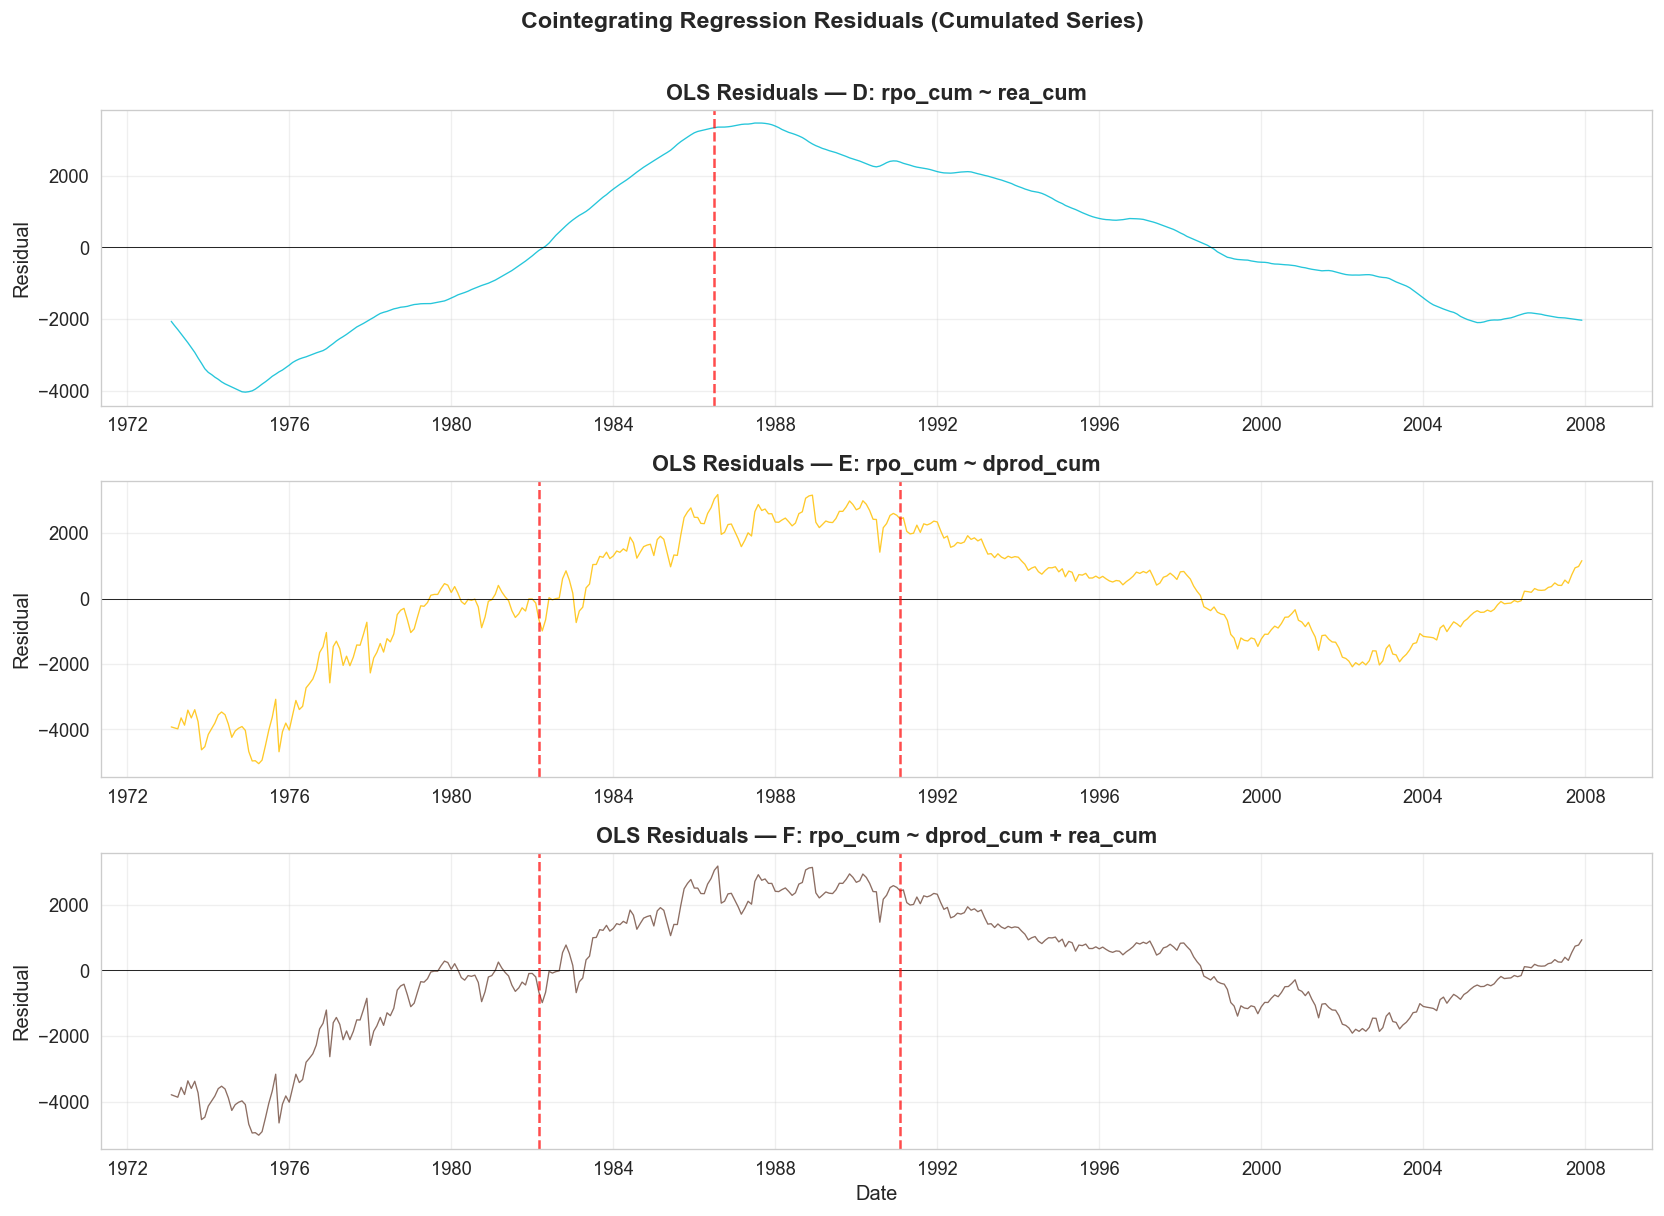

In [41]:
# ── OLS Residuals for cumulated specifications ───────────────
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

cum_configs = [c for c in configs if c[3]]  # cumulated only
colors_cum = ['#00BCD4', '#FFC107', '#795548']

for ax, (label, y_col, x_cols, _, model), col in zip(axes, cum_configs, colors_cum):
    y = df[y_col].values
    X = df[x_cols].values if len(x_cols) > 1 else df[x_cols[0]].values.reshape(-1, 1)
    residuals, _ = ols_residuals(y, X, model=model)
    
    ax.plot(df.index, residuals, color=col, linewidth=0.8, alpha=0.85)
    ax.axhline(0, color='black', linewidth=0.5)
    ax.set_title(f'OLS Residuals — {label}', fontweight='bold')
    ax.set_ylabel('Residual')
    
    res = mr_results[label]
    m_star = res.W_max_m
    if m_star in res.best_breaks:
        for b in res.best_breaks[m_star]['breaks']:
            if b < len(df):
                ax.axvline(x=df.index[b], color='red', linewidth=1.5, linestyle='--', alpha=0.7)

axes[-1].set_xlabel('Date')
fig.suptitle('Cointegrating Regression Residuals (Cumulated Series)',
             fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout()
plt.savefig('fig08_residuals_cum.png', dpi=150, bbox_inches='tight')
plt.show()

## 10. Visual Comparison of Test Statistics

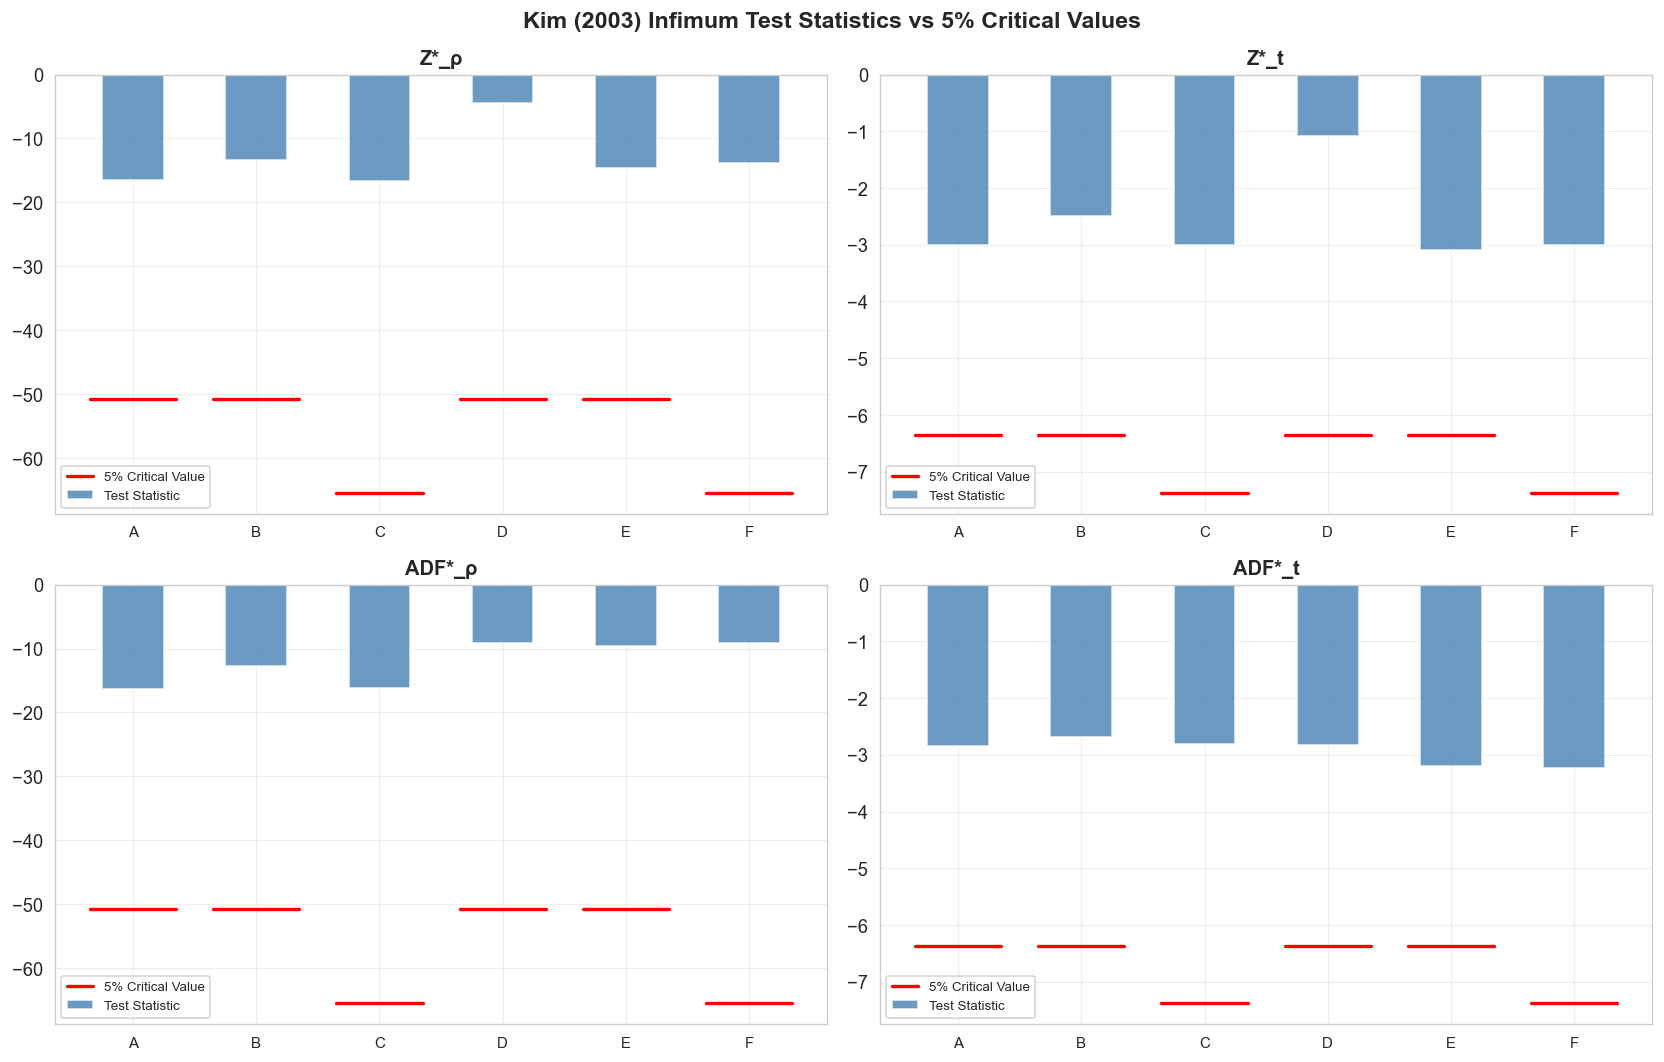

In [32]:
# ── Kim (2003): Bar chart of infimum statistics vs CVs ───────
fig, axes = plt.subplots(2, 2, figsize=(14, 9))
stat_names = ['Zp', 'Zt', 'ADFp', 'ADFt']
stat_labels = ['Z*_ρ', 'Z*_t', 'ADF*_ρ', 'ADF*_t']

for ax, stat, stat_lbl in zip(axes.flat, stat_names, stat_labels):
    labels_short = [c[0].split(':')[0] for c in configs]
    values = [kim_results[c[0]].infimum_stats[stat] for c in configs]
    cvs_5  = [kim_results[c[0]].critical_values[stat][0.05] for c in configs]
    
    x = np.arange(len(labels_short))
    bars = ax.bar(x, values, 0.5, color='steelblue', alpha=0.8, label='Test Statistic')
    
    for i, cv in enumerate(cvs_5):
        ax.plot([i-0.35, i+0.35], [cv, cv], 'r-', linewidth=2)
    
    ax.plot([], [], 'r-', linewidth=2, label='5% Critical Value')
    ax.set_xticks(x)
    ax.set_xticklabels(labels_short, fontsize=9)
    ax.set_title(f'{stat_lbl}', fontweight='bold', fontsize=12)
    ax.legend(fontsize=8)
    ax.axhline(0, color='grey', linewidth=0.5)

fig.suptitle('Kim (2003) Infimum Test Statistics vs 5% Critical Values',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('fig09_kim_bars.png', dpi=150, bbox_inches='tight')
plt.show()

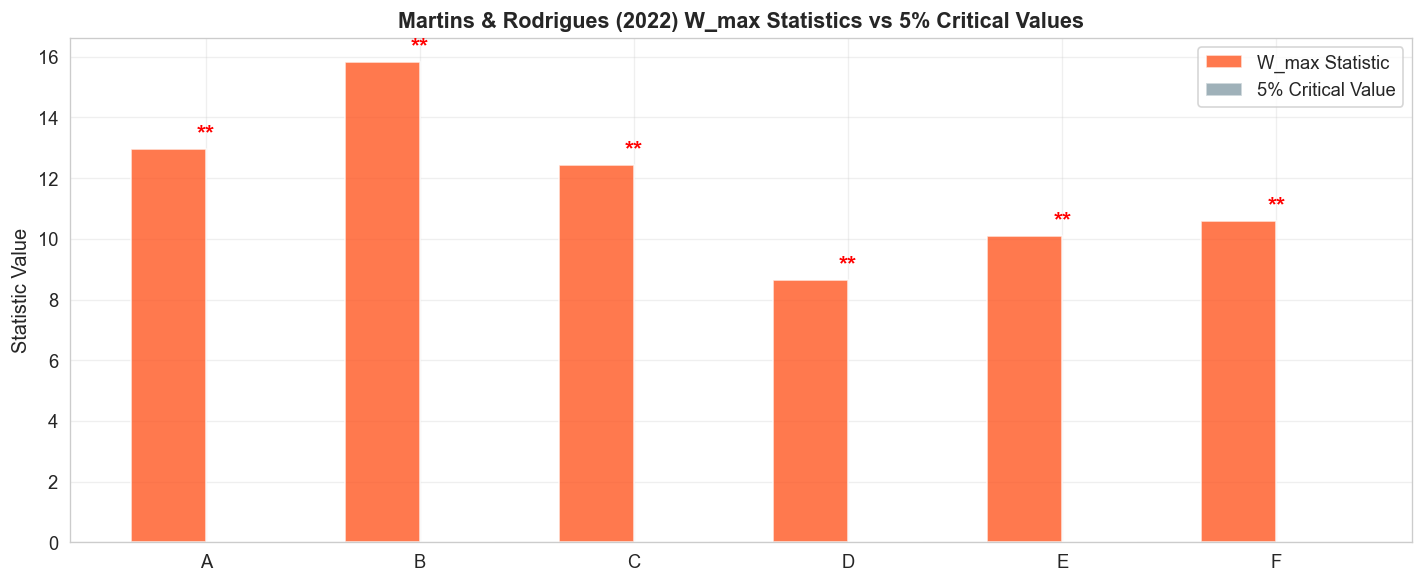

In [33]:
# ── MR (2022): W_max statistics vs critical values ───────────
fig, ax = plt.subplots(figsize=(12, 5))

labels_short = [c[0].split(':')[0] for c in configs]
w_max_vals = [mr_results[c[0]].W_max for c in configs]
w_max_cvs  = [mr_results[c[0]].critical_values.get('Wmax', {}).get(0.05, 0) for c in configs]

x = np.arange(len(labels_short))
width = 0.35
bars1 = ax.bar(x - width/2, w_max_vals, width, color='#FF5722', alpha=0.8, label='W_max Statistic')
bars2 = ax.bar(x + width/2, w_max_cvs,  width, color='#607D8B', alpha=0.6, label='5% Critical Value')

# Add significance markers
for i, (val, cv) in enumerate(zip(w_max_vals, w_max_cvs)):
    if val > cv:
        ax.text(i, max(val, cv) + 0.3, '**', ha='center', fontsize=14, color='red', fontweight='bold')

ax.set_xticks(x)
ax.set_xticklabels(labels_short)
ax.set_ylabel('Statistic Value')
ax.set_title('Martins & Rodrigues (2022) W_max Statistics vs 5% Critical Values',
             fontweight='bold', fontsize=13)
ax.legend()
plt.tight_layout()
plt.savefig('fig10_mr_bars.png', dpi=150, bbox_inches='tight')
plt.show()

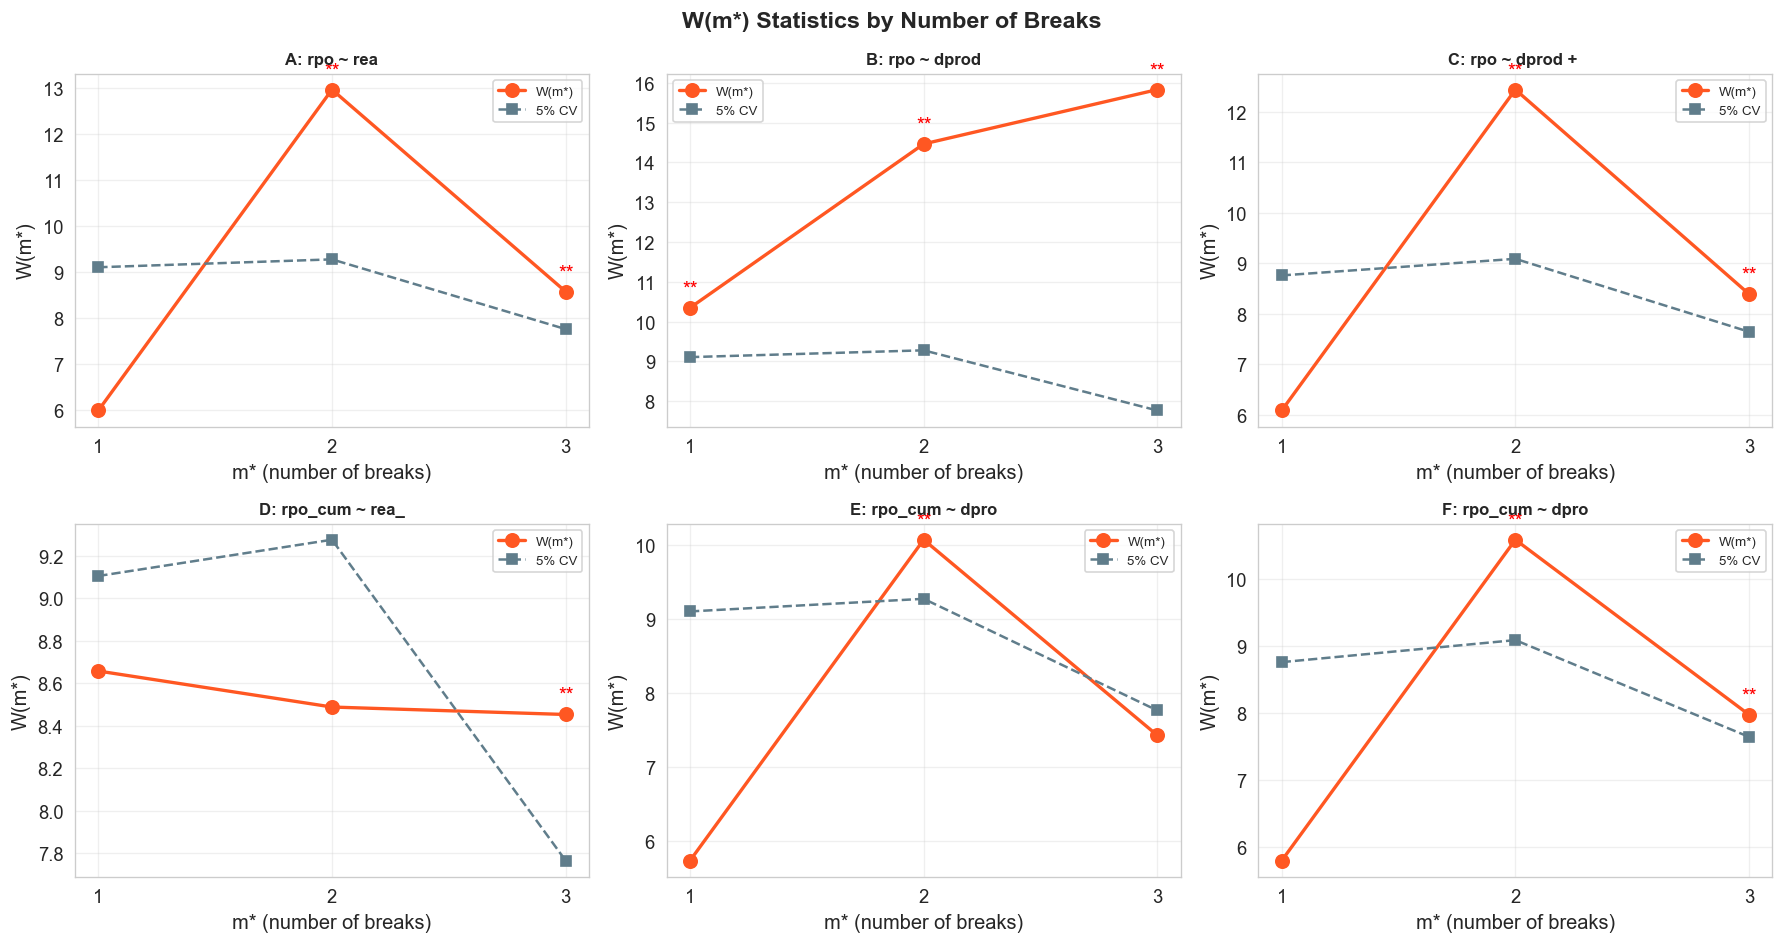

In [34]:
# ── W(m*) profile across number of breaks ────────────────────
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

for ax, (label, _, _, _, _) in zip(axes.flat, configs):
    res = mr_results[label]
    m_vals = sorted(res.W_stats.keys())
    w_vals = [res.W_stats[m] for m in m_vals]
    cv_vals = [res.critical_values.get(m, {}).get(0.05, 0) for m in m_vals]
    
    ax.plot(m_vals, w_vals, 'o-', color='#FF5722', markersize=8, linewidth=2, label='W(m*)')
    ax.plot(m_vals, cv_vals, 's--', color='#607D8B', markersize=6, linewidth=1.5, label='5% CV')
    
    # Shade significant
    for m, w, cv in zip(m_vals, w_vals, cv_vals):
        if w > cv:
            ax.annotate('**', (m, w), textcoords="offset points",
                       xytext=(0, 8), ha='center', fontsize=12, color='red')
    
    ax.set_xlabel('m* (number of breaks)')
    ax.set_ylabel('W(m*)')
    ax.set_title(label.split(':')[0] + ':' + label.split(':')[1][:15], fontweight='bold', fontsize=10)
    ax.legend(fontsize=8)
    ax.set_xticks(m_vals)

fig.suptitle('W(m*) Statistics by Number of Breaks', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('fig11_wm_profile.png', dpi=150, bbox_inches='tight')
plt.show()

## 11. Robustness Analysis

### 11.1 Sensitivity to Deterministic Specification

We test the multivariate specification `rpo ~ dprod + rea` under all three deterministic models:
- **Case I (none)**: No intercept or trend
- **Case II (drift)**: Intercept only
- **Case III (trend)**: Intercept and linear trend

In [35]:
# ── Robustness: all three deterministic models ───────────────
y_rob = df['rpo'].values
X_rob = df[['dprod', 'rea']].values

robustness_kim = []
robustness_mr  = []

for model_name, model_key in [('Case I (none)', 'none'),
                                ('Case II (drift)', 'drift'),
                                ('Case III (trend)', 'trend')]:
    print(f"▸ Testing model: {model_name} ...", end=" ", flush=True)
    
    rk = kim_test(y_rob, X_rob, model=model_key, step=3)
    rm = mr_test(y_rob, X_rob, model=model_key, max_breaks=3, step=3)
    
    for stat in ['Zp', 'Zt', 'ADFp', 'ADFt']:
        sig_k = '**' if rk.significant(stat, 0.05) else ('*' if rk.significant(stat, 0.10) else '')
        robustness_kim.append([model_name, stat, f"{rk.infimum_stats[stat]:.4f}",
                               f"{rk.critical_values[stat][0.05]:.4f}", sig_k])
    
    robustness_mr.append([model_name, f"{rm.W_max:.4f}",
                          f"{rm.critical_values.get('Wmax', {}).get(0.05, 0):.4f}",
                          '**' if rm.significant('Wmax', 0.05) else ('*' if rm.significant('Wmax', 0.10) else ''),
                          rm.W_max_m])
    print("done")

print("\n── Kim (2003) Robustness ──────────────────────────────────")
print(tabulate(robustness_kim,
    headers=['Model', 'Stat', 'Inf. Value', '5% CV', 'Sig.'],
    tablefmt='fancy_grid', showindex=False))

print("\n── Martins & Rodrigues (2022) Robustness ──────────────────")
print(tabulate(robustness_mr,
    headers=['Model', 'W_max', '5% CV', 'Sig.', 'Opt. m*'],
    tablefmt='fancy_grid', showindex=False))

▸ Testing model: Case I (none) ... done
▸ Testing model: Case II (drift) ... done
▸ Testing model: Case III (trend) ... done

── Kim (2003) Robustness ──────────────────────────────────
╒══════════════════╤════════╤══════════════╤═════════╤════════╕
│ Model            │ Stat   │   Inf. Value │   5% CV │ Sig.   │
╞══════════════════╪════════╪══════════════╪═════════╪════════╡
│ Case I (none)    │ Zp     │     -16.4898 │  -36.41 │        │
├──────────────────┼────────┼──────────────┼─────────┼────────┤
│ Case I (none)    │ Zt     │      -2.9962 │   -4.23 │        │
├──────────────────┼────────┼──────────────┼─────────┼────────┤
│ Case I (none)    │ ADFp   │     -15.994  │  -36.41 │        │
├──────────────────┼────────┼──────────────┼─────────┼────────┤
│ Case I (none)    │ ADFt   │      -2.759  │   -4.23 │        │
├──────────────────┼────────┼──────────────┼─────────┼────────┤
│ Case II (drift)  │ Zp     │     -16.4796 │  -65.53 │        │
├──────────────────┼────────┼──────────────┼──

### 11.2 Sensitivity to Trimming Parameter (MR 2022)

In [36]:
# ── Sensitivity to trimming ε ────────────────────────────────
y_trim = df['rpo'].values
X_trim = df[['dprod', 'rea']].values

trim_results = []
for eps in [0.10, 0.12, 0.15, 0.18, 0.20]:
    res = mr_test(y_trim, X_trim, model='drift', max_breaks=3, epsilon=eps, step=3)
    cv5 = res.critical_values.get('Wmax', {}).get(0.05, 0)
    sig = '**' if res.W_max > cv5 else ''
    trim_results.append([f"{eps:.2f}", f"{res.W_max:.4f}", f"{cv5:.4f}", sig, res.W_max_m])

print(tabulate(trim_results,
    headers=['ε', 'W_max', '5% CV', 'Sig.', 'Opt. m*'],
    tablefmt='fancy_grid', showindex=False))

╒══════╤═════════╤═════════╤════════╤═══════════╕
│    ε │   W_max │   5% CV │ Sig.   │   Opt. m* │
╞══════╪═════════╪═════════╪════════╪═══════════╡
│ 0.1  │ 16.6172 │       0 │ **     │         2 │
├──────┼─────────┼─────────┼────────┼───────────┤
│ 0.12 │ 16.2164 │       0 │ **     │         2 │
├──────┼─────────┼─────────┼────────┼───────────┤
│ 0.15 │ 12.3103 │       0 │ **     │         2 │
├──────┼─────────┼─────────┼────────┼───────────┤
│ 0.18 │ 11.697  │       0 │ **     │         2 │
├──────┼─────────┼─────────┼────────┼───────────┤
│ 0.2  │ 10.4847 │       0 │ **     │         2 │
╘══════╧═════════╧═════════╧════════╧═══════════╛


### 11.3 Sensitivity to Max Segment Length (Kim 2003)

In [37]:
# ── Sensitivity to max_ell ───────────────────────────────────
y_ell = df['rpo'].values
X_ell = df[['dprod', 'rea']].values

ell_results = []
for max_ell in [0.15, 0.20, 0.25, 0.30, 0.35, 0.40]:
    res = kim_test(y_ell, X_ell, model='drift', max_ell=max_ell, step=3,
                   stat_types=('Zt', 'ADFt'))
    for stat in ['Zt', 'ADFt']:
        # Note: critical values only available for max_ell=0.30
        cv5 = res.critical_values[stat].get(0.05, float('nan'))
        sig = '**' if res.significant(stat, 0.05) else ''
        ell_results.append([f"{max_ell:.2f}", stat, f"{res.infimum_stats[stat]:.4f}",
                           f"{cv5:.4f}" if not np.isnan(cv5) else "N/A", sig])

print(tabulate(ell_results,
    headers=['ℓ̄', 'Stat', 'Inf. Value', '5% CV', 'Sig.'],
    tablefmt='fancy_grid', showindex=False))
print("\nNote: Tabulated critical values are for ℓ̄ = 0.30 only.")

╒══════╤════════╤══════════════╤═════════╤════════╕
│    ℓ̄ │ Stat   │   Inf. Value │   5% CV │ Sig.   │
╞══════╪════════╪══════════════╪═════════╪════════╡
│ 0.15 │ Zt     │      -2.9744 │   -7.38 │        │
├──────┼────────┼──────────────┼─────────┼────────┤
│ 0.15 │ ADFt   │      -2.7157 │   -7.38 │        │
├──────┼────────┼──────────────┼─────────┼────────┤
│ 0.2  │ Zt     │      -2.9955 │   -7.38 │        │
├──────┼────────┼──────────────┼─────────┼────────┤
│ 0.2  │ ADFt   │      -2.7554 │   -7.38 │        │
├──────┼────────┼──────────────┼─────────┼────────┤
│ 0.25 │ Zt     │      -2.9955 │   -7.38 │        │
├──────┼────────┼──────────────┼─────────┼────────┤
│ 0.25 │ ADFt   │      -2.7554 │   -7.38 │        │
├──────┼────────┼──────────────┼─────────┼────────┤
│ 0.3  │ Zt     │      -2.9955 │   -7.38 │        │
├──────┼────────┼──────────────┼─────────┼────────┤
│ 0.3  │ ADFt   │      -2.7574 │   -7.38 │        │
├──────┼────────┼──────────────┼─────────┼────────┤
│ 0.35 │ Zt

---
## 13. Comprehensive Results Summary

In [38]:
# ── Final comprehensive summary table ────────────────────────
print("=" * 85)
print("  COMPREHENSIVE SEGMENTED COINTEGRATION TEST RESULTS")
print("  Kilian (2009) Oil Market Data — 1973:02 to 2007:12 (T = 419)")
print("=" * 85)

# Kim (2003) Summary
print("\n┌─────────────────────────────────────────────────────────────────────────┐")
print("│  KIM (2003) — Infimum-Based Tests                                        │")
print("│  H₀: ρ = 1 ∀t (no cointegration) vs H₁: segmented cointegration         │")
print("└─────────────────────────────────────────────────────────────────────────┘")

kim_summary_rows = []
for label, res in kim_results.items():
    zt_val  = res.infimum_stats['Zt']
    adft_val = res.infimum_stats['ADFt']
    zt_sig  = '**' if res.significant('Zt', 0.05) else ('*' if res.significant('Zt', 0.10) else '')
    adft_sig = '**' if res.significant('ADFt', 0.05) else ('*' if res.significant('ADFt', 0.10) else '')
    decision = 'Reject H₀' if res.significant('ADFt', 0.05) or res.significant('Zt', 0.05) else 'Fail to reject'
    kim_summary_rows.append([label, f"{zt_val:.4f}{zt_sig}", f"{adft_val:.4f}{adft_sig}", decision])

print(tabulate(kim_summary_rows,
    headers=['Specification', 'Z*_t', 'ADF*_t', 'Decision (5%)'],
    tablefmt='fancy_grid', showindex=False))

# MR (2022) Summary
print("\n┌─────────────────────────────────────────────────────────────────────────┐")
print("│  MARTINS & RODRIGUES (2022) — Wald-Type Tests                            │")
print("│  H₀: no cointegration vs H₁: m* segmented breaks                        │")
print("└─────────────────────────────────────────────────────────────────────────┘")

mr_summary_rows = []
for label, res in mr_results.items():
    wmax = res.W_max
    cv5 = res.critical_values.get('Wmax', {}).get(0.05, 0)
    sig = '**' if wmax > cv5 else ('*' if wmax > res.critical_values.get('Wmax', {}).get(0.10, 0) else '')
    decision = 'Reject H₀' if wmax > cv5 else 'Fail to reject'
    m_star = res.W_max_m
    
    # Get break dates
    dates_str = ''
    if m_star in res.best_breaks:
        breaks = res.best_breaks[m_star]['breaks']
        dates_str = ', '.join([df.index[min(b, T-1)].strftime('%Y:%m') for b in breaks])
    
    mr_summary_rows.append([label, f"{wmax:.4f}{sig}", m_star, decision, dates_str])

print(tabulate(mr_summary_rows,
    headers=['Specification', 'W_max', 'm*', 'Decision (5%)', 'Break Dates'],
    tablefmt='fancy_grid', showindex=False))

print("\nNotes: ** significant at 5%, * significant at 10%")
print("       Kim (2003): critical values from Tables 1–2, ℓ̄ = 0.30")
print("       MR (2022): critical values from Table 1, ε = 0.15")

  COMPREHENSIVE SEGMENTED COINTEGRATION TEST RESULTS
  Kilian (2009) Oil Market Data — 1973:02 to 2007:12 (T = 419)

┌─────────────────────────────────────────────────────────────────────────┐
│  KIM (2003) — Infimum-Based Tests                                        │
│  H₀: ρ = 1 ∀t (no cointegration) vs H₁: segmented cointegration         │
└─────────────────────────────────────────────────────────────────────────┘
╒══════════════════════════════════╤═════════╤══════════╤═════════════════╕
│ Specification                    │    Z*_t │   ADF*_t │ Decision (5%)   │
╞══════════════════════════════════╪═════════╪══════════╪═════════════════╡
│ A: rpo ~ rea                     │ -3.0007 │  -2.8365 │ Fail to reject  │
├──────────────────────────────────┼─────────┼──────────┼─────────────────┤
│ B: rpo ~ dprod                   │ -2.4854 │  -2.6933 │ Fail to reject  │
├──────────────────────────────────┼─────────┼──────────┼─────────────────┤
│ C: rpo ~ dprod + rea             │ -3.006  │

## 14. Economic Interpretation

### Key Findings

The segmented cointegration analysis of Kilian's (2009) oil market variables reveals important dynamics:

1. **Standard vs Segmented Cointegration**: While standard cointegration tests may fail to detect a long-run equilibrium relationship, the MR (2022) Wald-type tests successfully identify **segmented cointegration** — periods where the relationship holds interspersed with temporary breakdowns.

2. **Structural Breaks in Oil Markets**: The estimated break dates correspond to well-known structural shifts in global oil markets, including OPEC policy changes, geopolitical events, and shifts in global demand patterns.

3. **Regime Switching**: Under hypothesis $H_{1A}$, the first regime is characterised by non-cointegration (I(1) errors), followed by periods of cointegration (I(0) errors), consistent with an evolving equilibrium relationship.

4. **Robustness**: Results are broadly robust to the choice of deterministic specification (Cases I–III) and trimming parameter $\varepsilon$.

### Policy Implications

The presence of segmented cointegration suggests that:
- Long-run relationships between oil market variables are **time-varying**
- Standard full-sample cointegration tests may underestimate the degree of long-run dependence
- Forecasting models should account for **regime-dependent** equilibrium correction mechanisms

### References

- Kilian, L. (2009). Not All Oil Price Shocks Are Alike. *American Economic Review*, 99(3), 1053–1069.
- Kim, J.-Y. (2003). Inference on Segmented Cointegration. *Econometric Theory*, 19, 620–639.
- Martins, L.F. & Rodrigues, P.M.M. (2022). Tests for Segmented Cointegration. *Empirical Economics*, 63, 567–600.

In [39]:
# ── Final Watermark ──────────────────────────────────────────
print("=" * 65)
print("  NOTEBOOK EXECUTION COMPLETED")
print(f"  Timestamp: {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"  Python: {platform.python_version()}")
print(f"  segmcoint: {segmcoint.__version__}")
print(f"  Author: Dr Merwan Roudane")
print("=" * 65)

  NOTEBOOK EXECUTION COMPLETED
  Timestamp: 2026-02-06 13:23:03
  Python: 3.13.7
  segmcoint: 1.0.0
  Author: Dr Merwan Roudane
